STEP 1: LOADING DATA AND CREATING TARGET VARIABLE

Dataset loaded: 651,936 rows, 34 columns
Date range: 01/01/2017 to 31/12/2022

Aggregating to song level...
Unique songs: 9,161

Weeks in charts distribution:
count    9161.000000
mean       71.164283
std       172.927156
min         1.000000
25%         2.000000
50%         9.000000
75%        56.000000
max      2602.000000
Name: Weeks_In_Charts, dtype: float64

SUCCESS CATEGORY DISTRIBUTION

Number of songs in each category:
Long-Term Hit: 3,621 songs (39.5%)
Brief Hit: 2,453 songs (26.8%)
Flop: 1,783 songs (19.5%)
Sustained Success: 1,304 songs (14.2%)


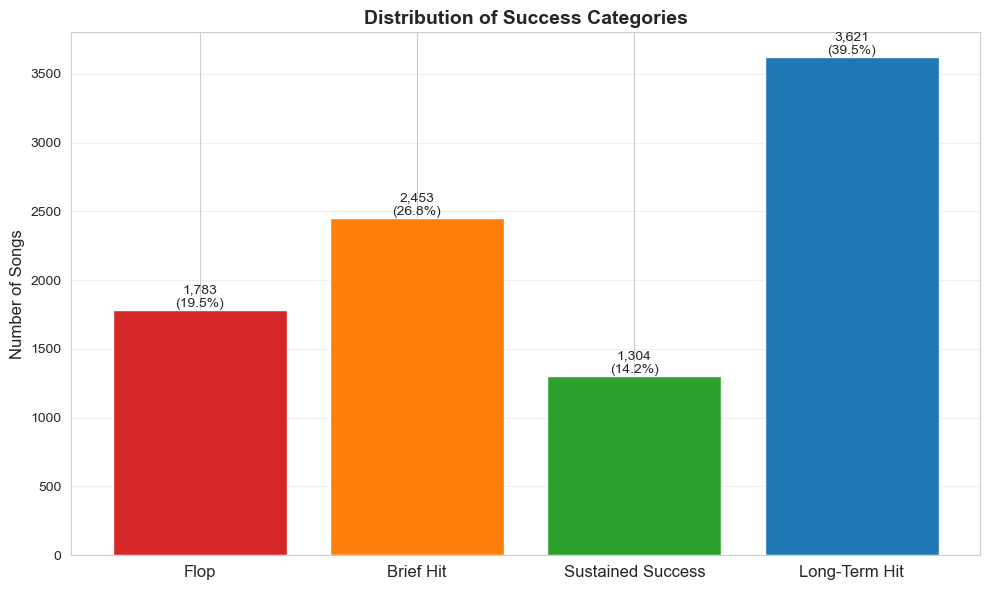


Target variable created successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("STEP 1: LOADING DATA AND CREATING TARGET VARIABLE")

# Load your dataset with clusters
df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')

print(f"\nDataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Convert Date to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Create song-level aggregation to count weeks in charts
print("\nAggregating to song level...")
song_weeks = df.groupby('id').agg({
    'Date': 'count',  # This counts number of weeks in charts
    'Title': 'first',
    'Artists': 'first',
    'Rank': 'min'  # Best rank achieved
}).reset_index()

song_weeks.columns = ['id', 'Weeks_In_Charts', 'Title', 'Artists', 'Best_Rank']

print(f"Unique songs: {len(song_weeks):,}")
print(f"\nWeeks in charts distribution:")
print(song_weeks['Weeks_In_Charts'].describe())

# Create success category based on weeks in charts
def categorize_success(weeks):
    """
    Categorize songs into success levels based on chart longevity
    """
    if weeks < 2:
        return 'Flop'
    elif weeks >= 2 and weeks < 8:
        return 'Brief Hit'
    elif weeks >= 8 and weeks < 20:
        return 'Sustained Success'
    else:  # weeks >= 20
        return 'Long-Term Hit'

# Apply categorization
song_weeks['Success_Category'] = song_weeks['Weeks_In_Charts'].apply(categorize_success)

print("\nSUCCESS CATEGORY DISTRIBUTION")

category_counts = song_weeks['Success_Category'].value_counts()
print("\nNumber of songs in each category:")
for category, count in category_counts.items():
    percent = (count / len(song_weeks)) * 100
    print(f"{category}: {count:,} songs ({percent:.1f}%)")

# Visualize distribution
plt.figure(figsize=(10, 6))
category_order = ['Flop', 'Brief Hit', 'Sustained Success', 'Long-Term Hit']
category_counts_ordered = song_weeks['Success_Category'].value_counts().reindex(category_order)

bars = plt.bar(range(len(category_counts_ordered)), category_counts_ordered.values, 
               color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
plt.xticks(range(len(category_counts_ordered)), category_counts_ordered.index, fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.title('Distribution of Success Categories', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({category_counts_ordered.values[i]/len(song_weeks)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('success_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTarget variable created successfully!")

In [3]:
print("STEP 2: MERGING CLUSTER FEATURES WITH TARGET")

# Get cluster features for each song (use first appearance)
# Group by song ID and get the first row (earliest date)
song_features = df.sort_values('Date').groupby('id').first().reset_index()

# Select only the cluster columns and original features
cluster_columns = [
    'Sonic_Cluster',
    'Artist_Tier', 
    'Temporal_Cluster',
    'Performance_Cluster',
    'Geo_Cluster_ID',
    'Collab_Cluster_ID',
    'Evo_Cluster_ID'
]

# Original features that might be useful
original_features = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 
    'Acousticness', 'Instrumentalness', 'Valence',
    '# of Artist', '# of Nationality'
]

# Select features
features_to_keep = ['id'] + cluster_columns + original_features
song_features_selected = song_features[features_to_keep]

# Merge with target
final_data = song_features_selected.merge(
    song_weeks[['id', 'Success_Category', 'Weeks_In_Charts', 'Best_Rank']], 
    on='id', 
    how='inner'
)

print(f"\nFinal dataset shape: {final_data.shape}")
print(f"Features: {len(cluster_columns)} cluster features + {len(original_features)} original features")

# Check for missing values
print("Checking for Missing Values:")
missing_values = final_data.isnull().sum()
if missing_values.sum() > 0:
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("\ No missing values found!")

# Save the final dataset
final_data.to_csv('modeling_dataset.csv', index=False)
print("\ Saved: modeling_dataset.csv")

STEP 2: MERGING CLUSTER FEATURES WITH TARGET

Final dataset shape: (9161, 20)
Features: 7 cluster features + 9 original features
Checking for Missing Values:
\ No missing values found!
\ Saved: modeling_dataset.csv


STEP 3: EXPLORATORY DATA ANALYSIS


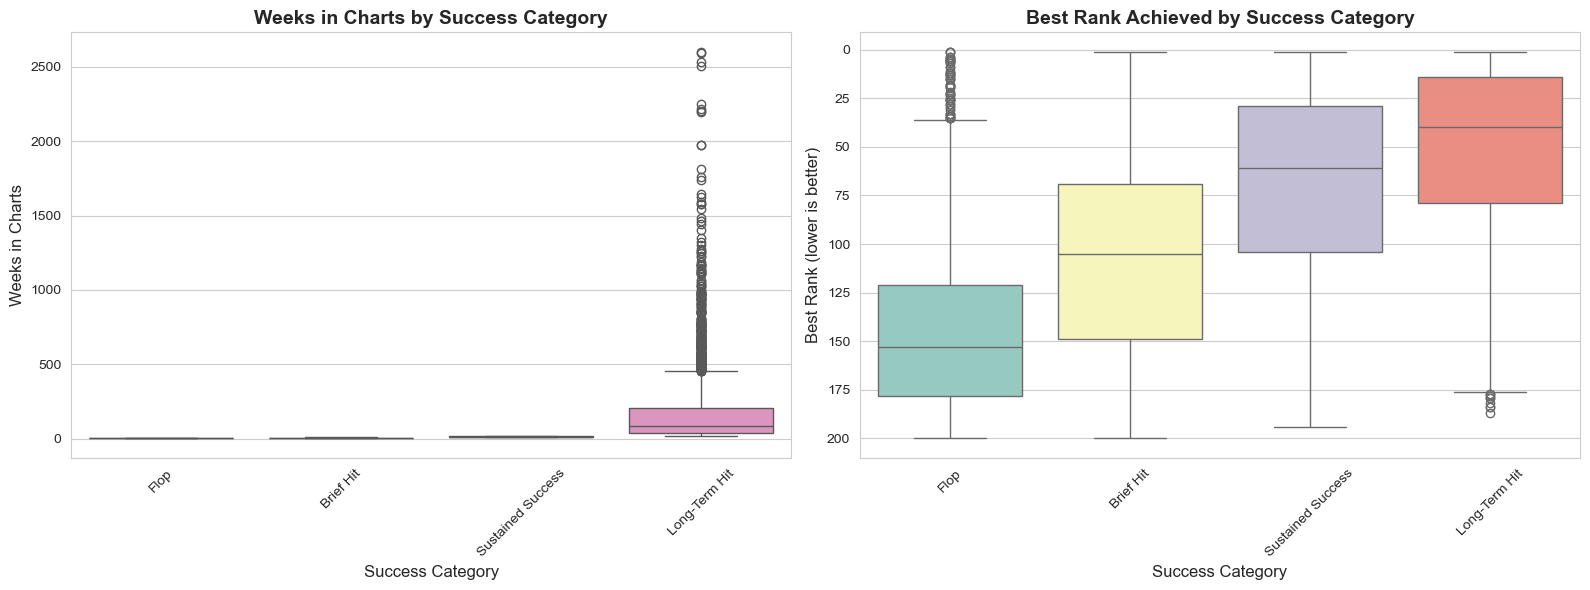


Key Statistics by Success Category:

Flop:
  Count: 1,783
  Avg Weeks: 1.0
  Avg Best Rank: 144.4

Brief Hit:
  Count: 2,453
  Avg Weeks: 3.8
  Avg Best Rank: 108.2

Sustained Success:
  Count: 1,304
  Avg Weeks: 12.2
  Avg Best Rank: 70.9

Long-Term Hit:
  Count: 3,621
  Avg Weeks: 172.6
  Avg Best Rank: 50.8


In [4]:
print("STEP 3: EXPLORATORY DATA ANALYSIS")

# 3.1: Relationship between weeks and category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot: Weeks by category
category_order = ['Flop', 'Brief Hit', 'Sustained Success', 'Long-Term Hit']
sns.boxplot(data=final_data, x='Success_Category', y='Weeks_In_Charts', 
            order=category_order, ax=axes[0], palette='Set2')
axes[0].set_title('Weeks in Charts by Success Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Success Category', fontsize=12)
axes[0].set_ylabel('Weeks in Charts', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Box plot: Best Rank by category
sns.boxplot(data=final_data, x='Success_Category', y='Best_Rank', 
            order=category_order, ax=axes[1], palette='Set3')
axes[1].set_title('Best Rank Achieved by Success Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Success Category', fontsize=12)
axes[1].set_ylabel('Best Rank (lower is better)', fontsize=12)
axes[1].invert_yaxis()  # Lower rank is better
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_target_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Statistics by Success Category:")
for category in category_order:
    category_data = final_data[final_data['Success_Category'] == category]
    print(f"\n{category}:")
    print(f"  Count: {len(category_data):,}")
    print(f"  Avg Weeks: {category_data['Weeks_In_Charts'].mean():.1f}")
    print(f"  Avg Best Rank: {category_data['Best_Rank'].mean():.1f}")

CLUSTER FEATURES ACROSS SUCCESS CATEGORIES


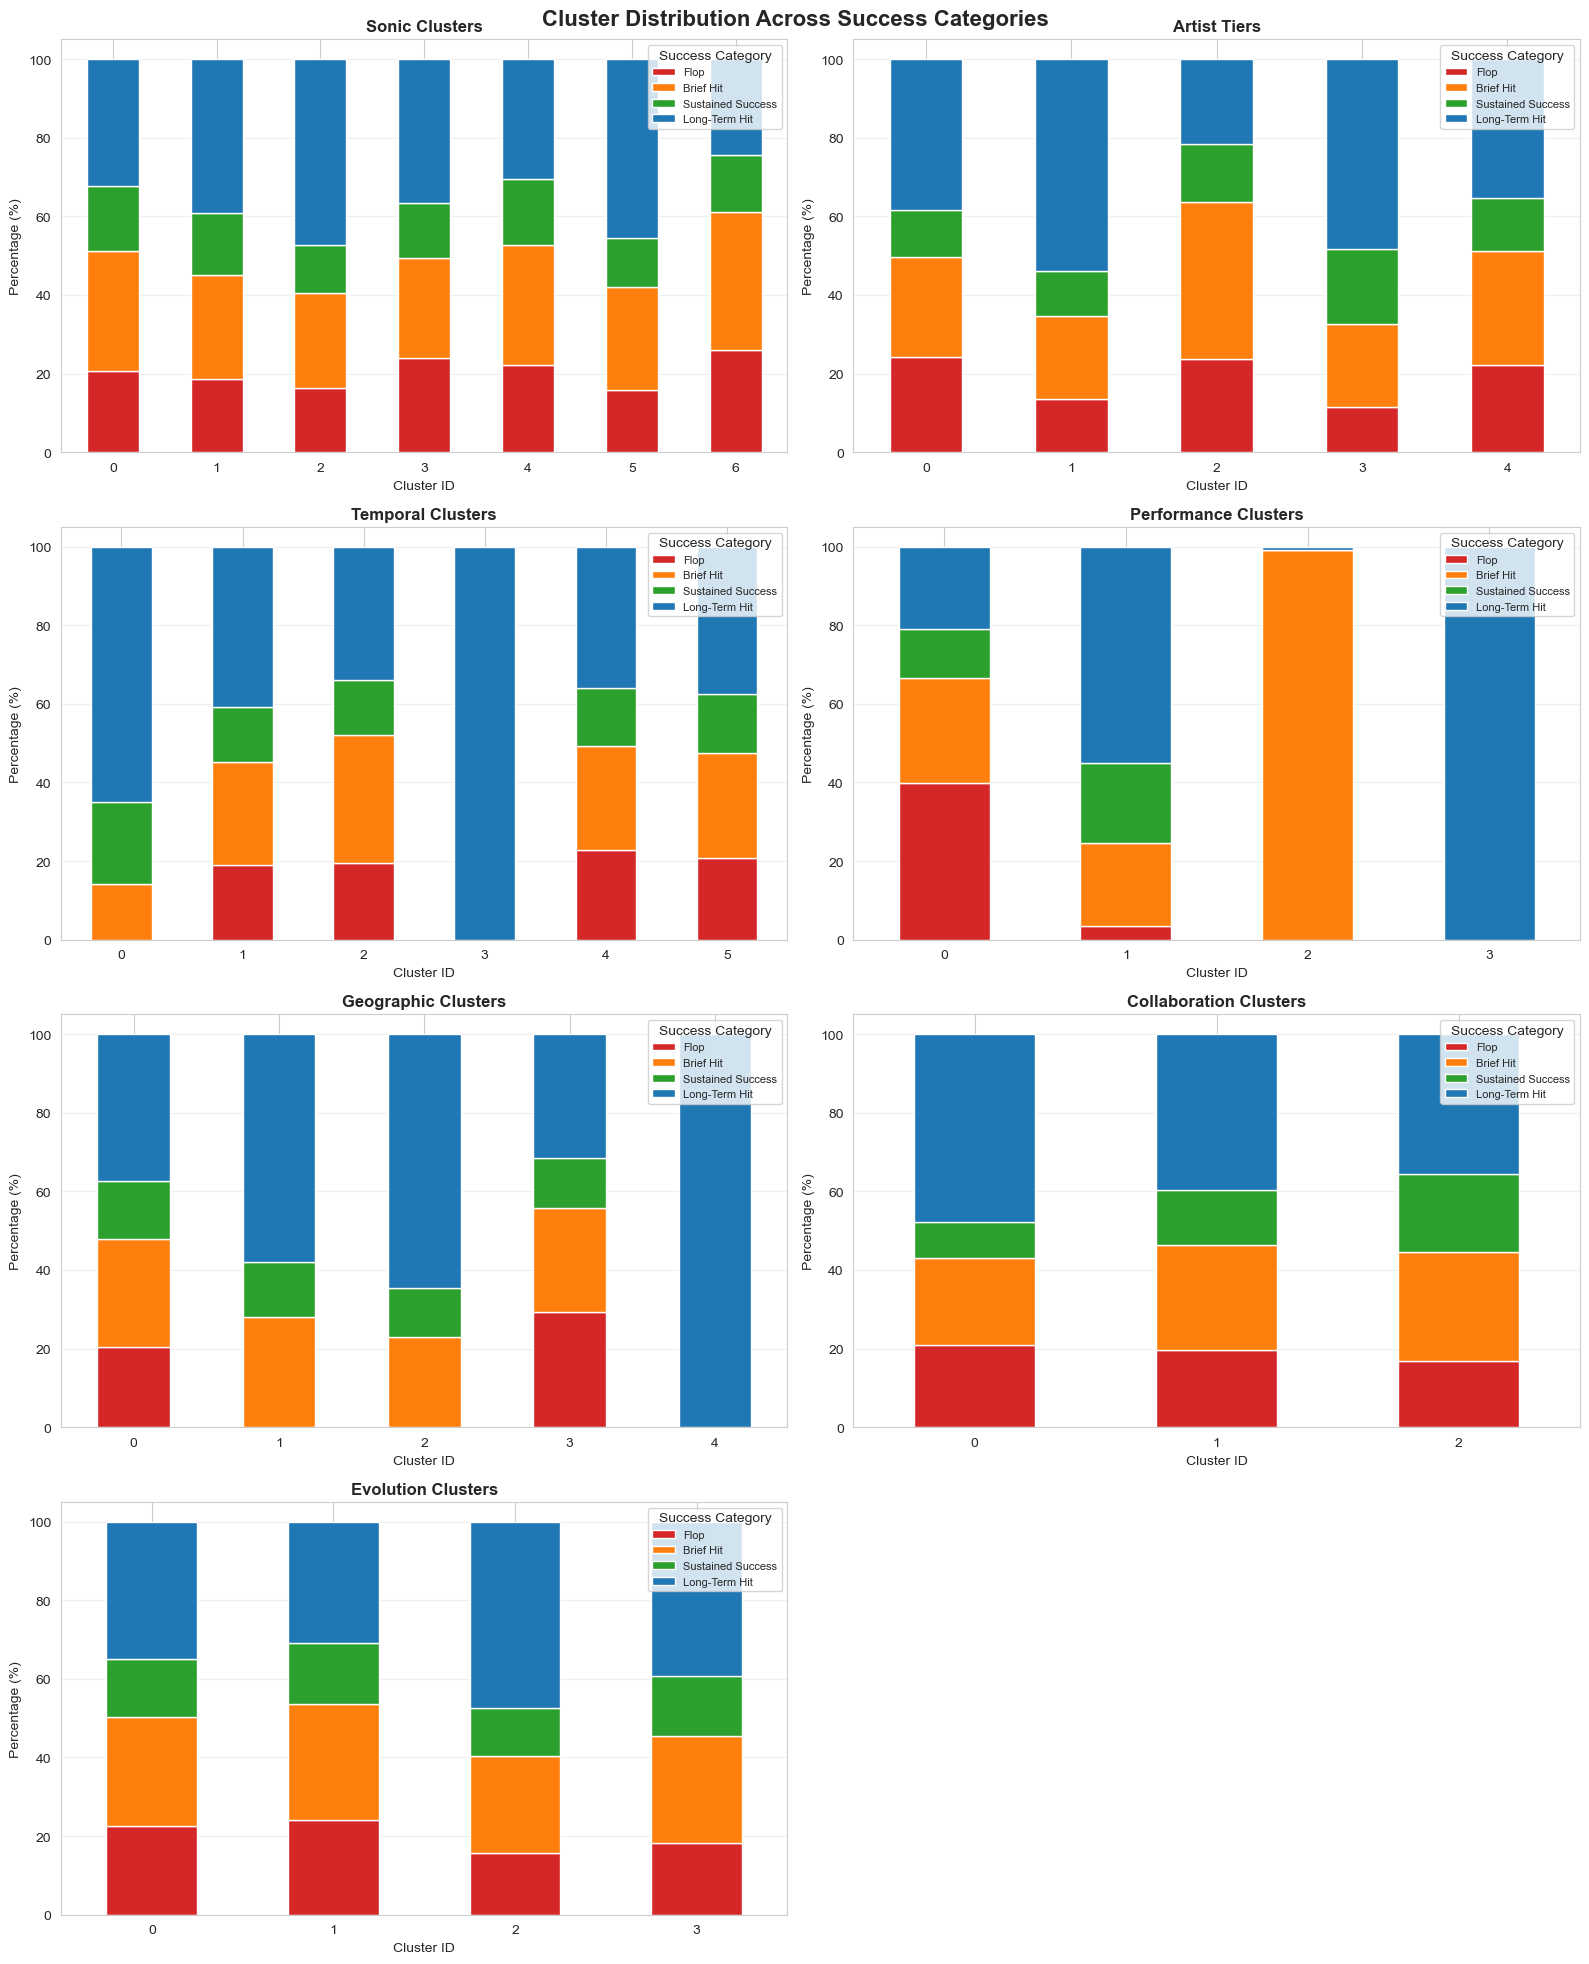


Artist Tier Distribution Across Success Categories:
Success_Category  Flop  Brief Hit  Sustained Success  Long-Term Hit
Artist_Tier                                                        
0                 24.2       25.6               11.8           38.4
1                 13.5       21.3               11.4           53.9
2                 23.6       40.0               14.6           21.7
3                 11.4       21.3               18.9           48.3
4                 22.2       29.0               13.6           35.3


In [5]:
print("CLUSTER FEATURES ACROSS SUCCESS CATEGORIES")

# Create visualizations for each cluster dimension
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Cluster Distribution Across Success Categories', fontsize=16, fontweight='bold')

cluster_info = [
    ('Sonic_Cluster', 'Sonic Clusters', axes[0, 0]),
    ('Artist_Tier', 'Artist Tiers', axes[0, 1]),
    ('Temporal_Cluster', 'Temporal Clusters', axes[1, 0]),
    ('Performance_Cluster', 'Performance Clusters', axes[1, 1]),
    ('Geo_Cluster_ID', 'Geographic Clusters', axes[2, 0]),
    ('Collab_Cluster_ID', 'Collaboration Clusters', axes[2, 1]),
    ('Evo_Cluster_ID', 'Evolution Clusters', axes[3, 0])
]

for col, title, ax in cluster_info:
    # Create cross-tabulation
    crosstab = pd.crosstab(final_data[col], final_data['Success_Category'], normalize='index') * 100
    crosstab = crosstab[category_order]  # Reorder columns
    
    # Plot stacked bar chart
    crosstab.plot(kind='bar', stacked=True, ax=ax, 
                  color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster ID', fontsize=10)
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.legend(title='Success Category', fontsize=8, loc='upper right')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

# Remove empty subplot
axes[3, 1].remove()

plt.tight_layout()
plt.savefig('eda_cluster_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics for most important cluster
print("\nArtist Tier Distribution Across Success Categories:")
artist_crosstab = pd.crosstab(final_data['Artist_Tier'], 
                               final_data['Success_Category'], 
                               normalize='index') * 100
artist_crosstab = artist_crosstab[category_order]
print(artist_crosstab.round(1))

ORIGINAL AUDIO FEATURES ACROSS SUCCESS CATEGORIES


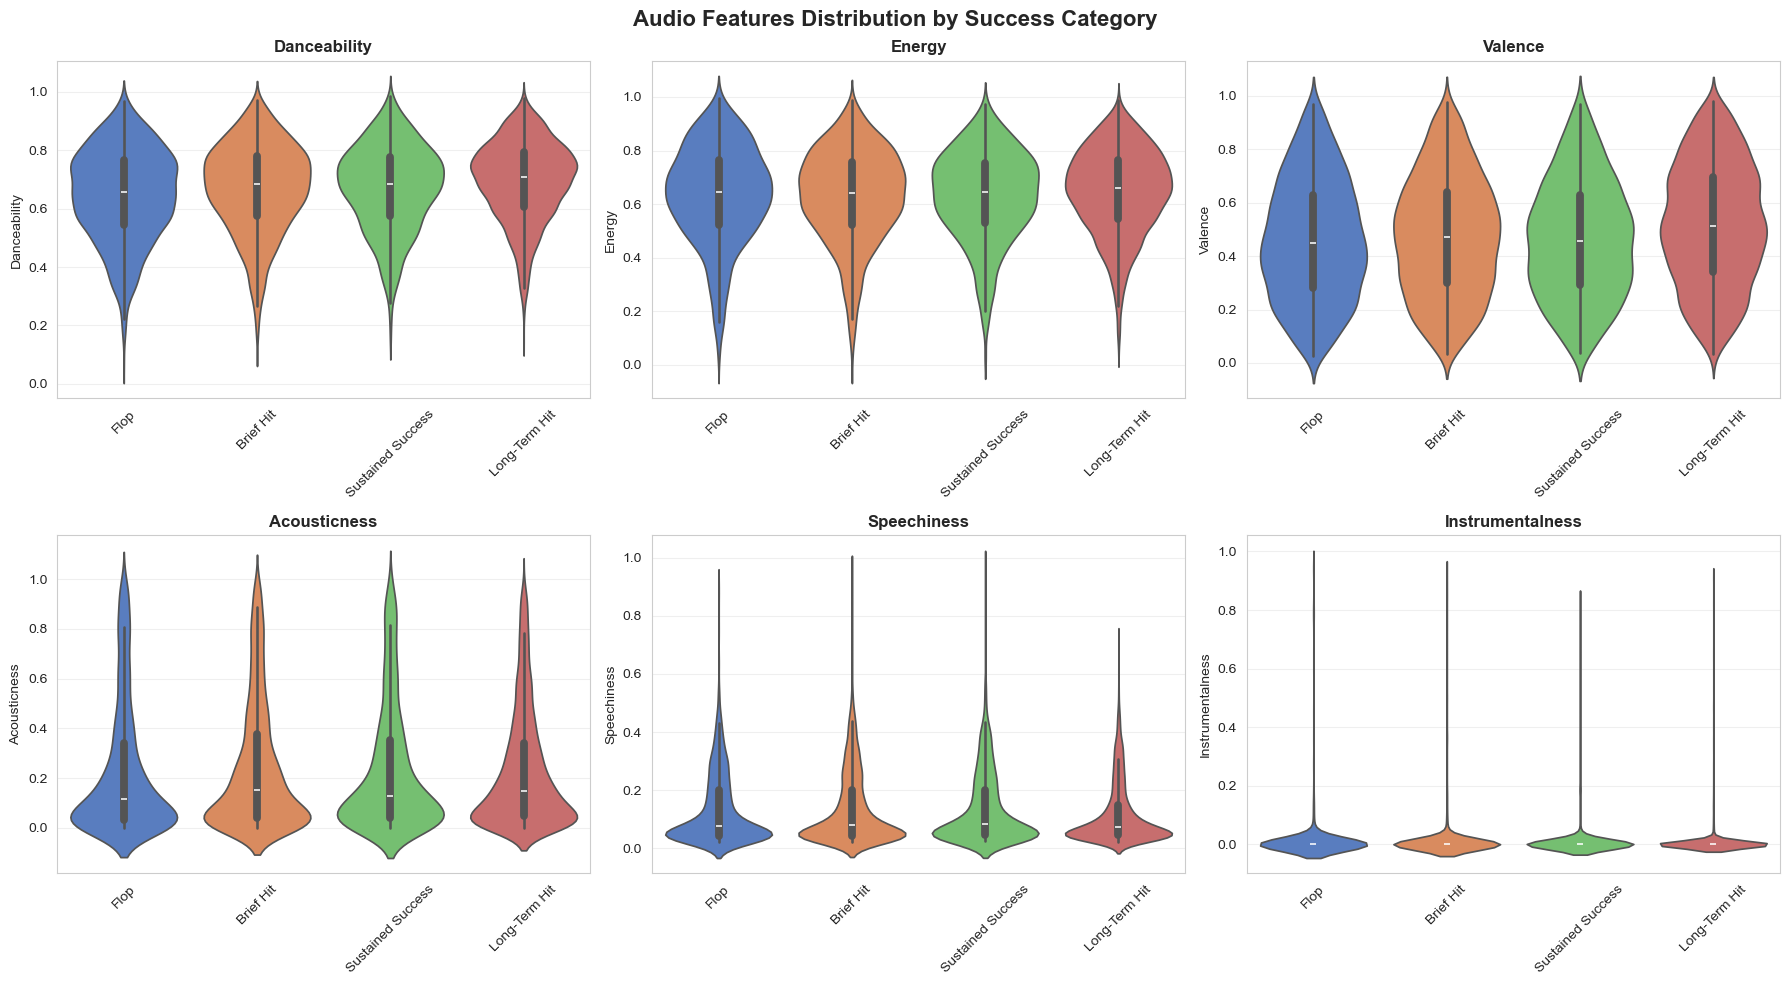


Average Audio Feature Values by Success Category:
                   Danceability  Energy  Valence  Acousticness  Speechiness  \
Success_Category                                                              
Flop                      0.646   0.633    0.461         0.228        0.135   
Brief Hit                 0.668   0.628    0.474         0.243        0.137   
Sustained Success         0.670   0.629    0.463         0.236        0.136   
Long-Term Hit             0.693   0.646    0.516         0.230        0.117   

                   Instrumentalness  
Success_Category                     
Flop                          0.018  
Brief Hit                     0.017  
Sustained Success             0.013  
Long-Term Hit                 0.010  


In [6]:
print("ORIGINAL AUDIO FEATURES ACROSS SUCCESS CATEGORIES")

# Select audio features
audio_features = ['Danceability', 'Energy', 'Valence', 'Acousticness', 
                  'Speechiness', 'Instrumentalness']

# Create violin plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Audio Features Distribution by Success Category', fontsize=16, fontweight='bold')

for idx, feature in enumerate(audio_features):
    row = idx // 3
    col = idx % 3
    
    sns.violinplot(data=final_data, x='Success_Category', y=feature, 
                   order=category_order, ax=axes[row, col], palette='muted')
    axes[row, col].set_title(feature, fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_audio_features.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate mean values by category
print("\nAverage Audio Feature Values by Success Category:")
audio_stats = final_data.groupby('Success_Category')[audio_features].mean()
audio_stats = audio_stats.reindex(category_order)
print(audio_stats.round(3))

CORRELATION ANALYSIS

Checking column types in final_data:
id                      object
Sonic_Cluster            int64
Artist_Tier              int64
Temporal_Cluster         int64
Performance_Cluster      int64
Geo_Cluster_ID           int64
Collab_Cluster_ID        int64
Evo_Cluster_ID           int64
Danceability           float64
Energy                 float64
Loudness               float64
Speechiness            float64
Acousticness           float64
Instrumentalness       float64
Valence                float64
# of Artist             object
# of Nationality        object
Success_Category        object
Weeks_In_Charts          int64
Best_Rank                int64
dtype: object
 Danceability - numeric, will include
 Energy - numeric, will include
 Loudness - numeric, will include
 Speechiness - numeric, will include
 Acousticness - numeric, will include
 Instrumentalness - numeric, will include
 Valence - numeric, will include
  # of Artist - exists but not numeric, will exclude


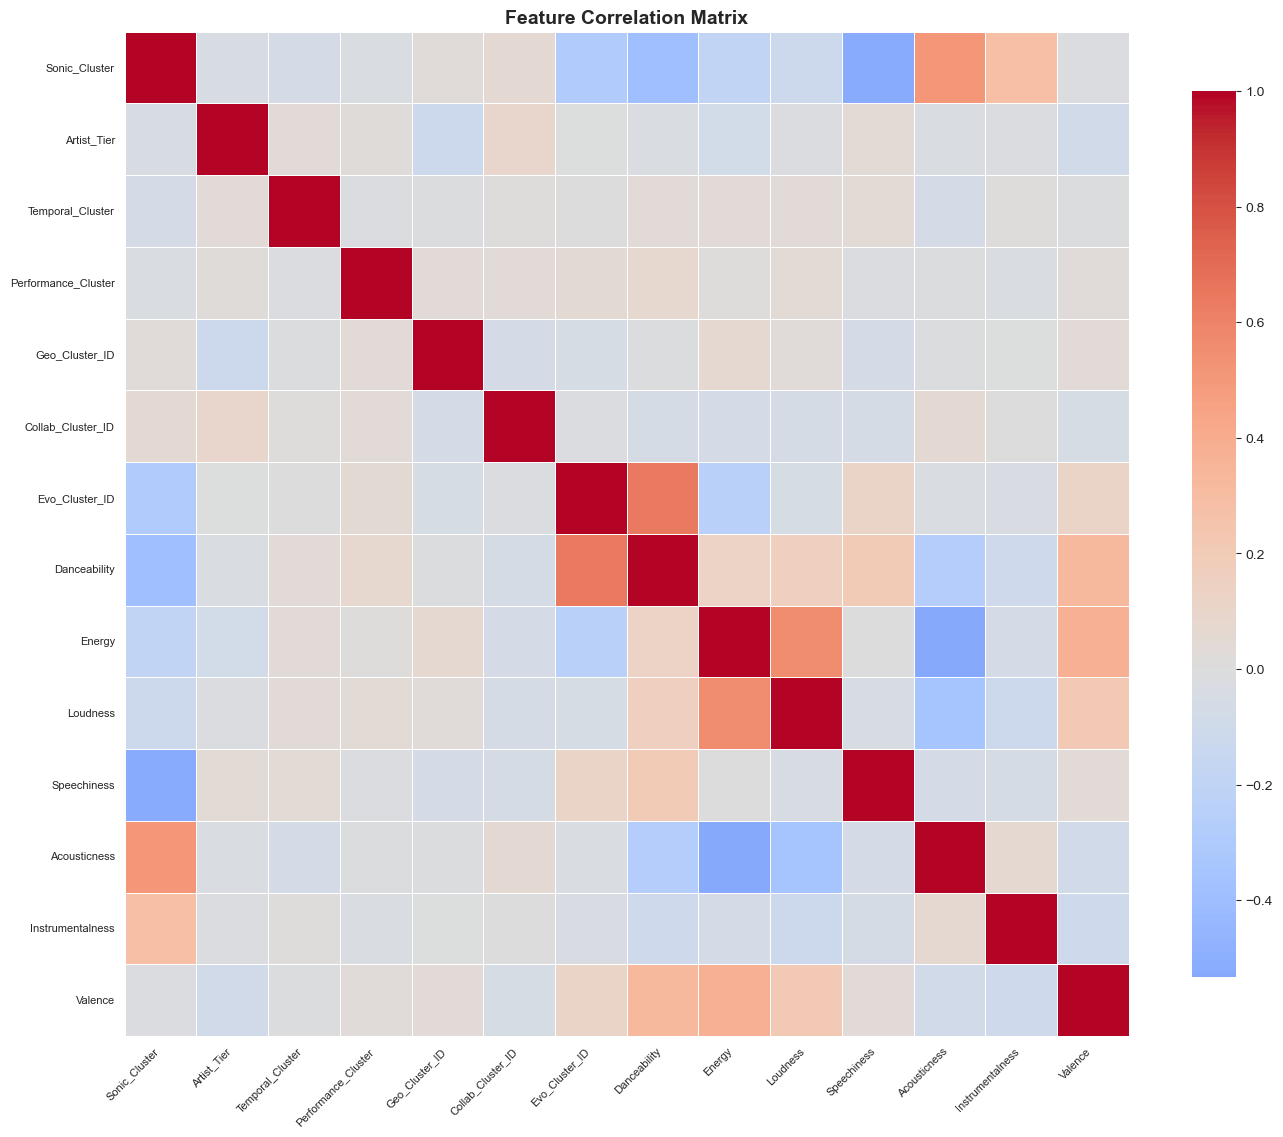

Highly Correlated Feature Pairs (|correlation| > 0.7):
 No highly correlated features found (good for modeling!)

 Correlation analysis complete


In [8]:
print("CORRELATION ANALYSIS")

# First, let's see what columns we actually have
print("\nChecking column types in final_data:")
print(final_data.dtypes)

# Select ONLY numeric columns that exist in the dataframe
# Cluster columns
cluster_columns = [
    'Sonic_Cluster',
    'Artist_Tier', 
    'Temporal_Cluster',
    'Performance_Cluster',
    'Geo_Cluster_ID',
    'Collab_Cluster_ID',
    'Evo_Cluster_ID'
]

# Original numeric features - let's verify which ones actually exist
potential_original_features = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 
    'Acousticness', 'Instrumentalness', 'Valence',
    '# of Artist', '# of Nationality'
]

# Check which columns actually exist and are numeric
original_features = []
for col in potential_original_features:
    if col in final_data.columns:
        # Check if it's numeric
        if pd.api.types.is_numeric_dtype(final_data[col]):
            original_features.append(col)
            print(f" {col} - numeric, will include")
        else:
            print(f"  {col} - exists but not numeric, will exclude")
    else:
        print(f" {col} - does not exist in dataframe")

# Verify cluster columns are numeric
print("\nVerifying cluster columns are numeric:")
cluster_columns_verified = []
for col in cluster_columns:
    if col in final_data.columns:
        if pd.api.types.is_numeric_dtype(final_data[col]):
            cluster_columns_verified.append(col)
            print(f" {col} - numeric")
        else:
            print(f"  {col} - not numeric, will exclude")
    else:
        print(f" {col} - does not exist in dataframe")

# Combine all verified numeric features
numerical_features = cluster_columns_verified + original_features

print(f"\n Total numeric features for correlation: {len(numerical_features)}")
print("\nFeatures to use:")
for i, feat in enumerate(numerical_features, 1):
    print(f"{i}. {feat}")

# Now create correlation matrix with only numeric features
print("\nCreating correlation matrix...")
correlation_matrix = final_data[numerical_features].corr()

print(" Correlation matrix created successfully!")

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('eda_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find highly correlated features (potential multicollinearity)
print("Highly Correlated Feature Pairs (|correlation| > 0.7):")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    print("\nFound correlated pairs:")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature 1']} <-> {pair['Feature 2']}: {pair['Correlation']:.3f}")
else:
    print(" No highly correlated features found (good for modeling!)")

print("\n Correlation analysis complete")

In [9]:
print("STEP 4: FEATURE PREPARATION (CORRECTED)")

# Use the verified numerical features from correlation analysis
print(f"\nUsing {len(numerical_features)} verified numeric features")

# Separate features and target
X = final_data[numerical_features].copy()
y = final_data['Success_Category'].copy()

# Check for any missing values
print("\n Checking for missing values in features:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print("\n  Found missing values:")
    print(missing_counts[missing_counts > 0])
    
    print("\n Filling missing values with median...")
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            median_value = X[col].median()
            X[col].fillna(median_value, inplace=True)
            print(f"  {col}: filled {missing_counts[col]} missing values with {median_value}")
    
    print(" Missing values handled")
else:
    print(" No missing values found")

# Verify all columns are numeric
print("\n Verifying all features are numeric:")
for col in X.columns:
    dtype = X[col].dtype
    if pd.api.types.is_numeric_dtype(X[col]):
        print(f" {col}: {dtype}")
    else:
        print(f"ERROR: {col} is not numeric: {dtype}")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Encode target variable to numbers for modeling
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nTarget encoding:")
for i, category in enumerate(label_encoder.classes_):
    count = (y_encoded == i).sum()
    print(f"  {category} → {i} ({count:,} samples)")

# Save the encoder for later use
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("\n Saved: label_encoder.pkl")

# Scale the features (important for some algorithms)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to dataframe for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeature Statistics After Scaling:")
print(f"Mean (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"Std Dev (should be ~1): {X_scaled_df.std().mean():.6f}")

# Verify scaling worked
print("\nFirst 3 features statistics:")
for col in X_scaled_df.columns[:3]:
    print(f"\n{col}:")
    print(f"  Mean: {X_scaled_df[col].mean():.6f}")
    print(f"  Std: {X_scaled_df[col].std():.6f}")

# Save the scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nSaved: feature_scaler.pkl")

print("\nFeature preparation complete")

STEP 4: FEATURE PREPARATION (CORRECTED)

Using 14 verified numeric features

 Checking for missing values in features:
 No missing values found

 Verifying all features are numeric:
 Sonic_Cluster: int64
 Artist_Tier: int64
 Temporal_Cluster: int64
 Performance_Cluster: int64
 Geo_Cluster_ID: int64
 Collab_Cluster_ID: int64
 Evo_Cluster_ID: int64
 Danceability: float64
 Energy: float64
 Loudness: float64
 Speechiness: float64
 Acousticness: float64
 Instrumentalness: float64
 Valence: float64

Feature matrix shape: (9161, 14)
Target variable shape: (9161,)

Target encoding:
  Brief Hit → 0 (2,453 samples)
  Flop → 1 (1,783 samples)
  Long-Term Hit → 2 (3,621 samples)
  Sustained Success → 3 (1,304 samples)

 Saved: label_encoder.pkl

Feature Statistics After Scaling:
Mean (should be ~0): -0.000000
Std Dev (should be ~1): 1.000055

First 3 features statistics:

Sonic_Cluster:
  Mean: 0.000000
  Std: 1.000055

Artist_Tier:
  Mean: 0.000000
  Std: 1.000055

Temporal_Cluster:
  Mean: 0.000

STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)

Total features: 14
Total variance explained by all components: 100.00%


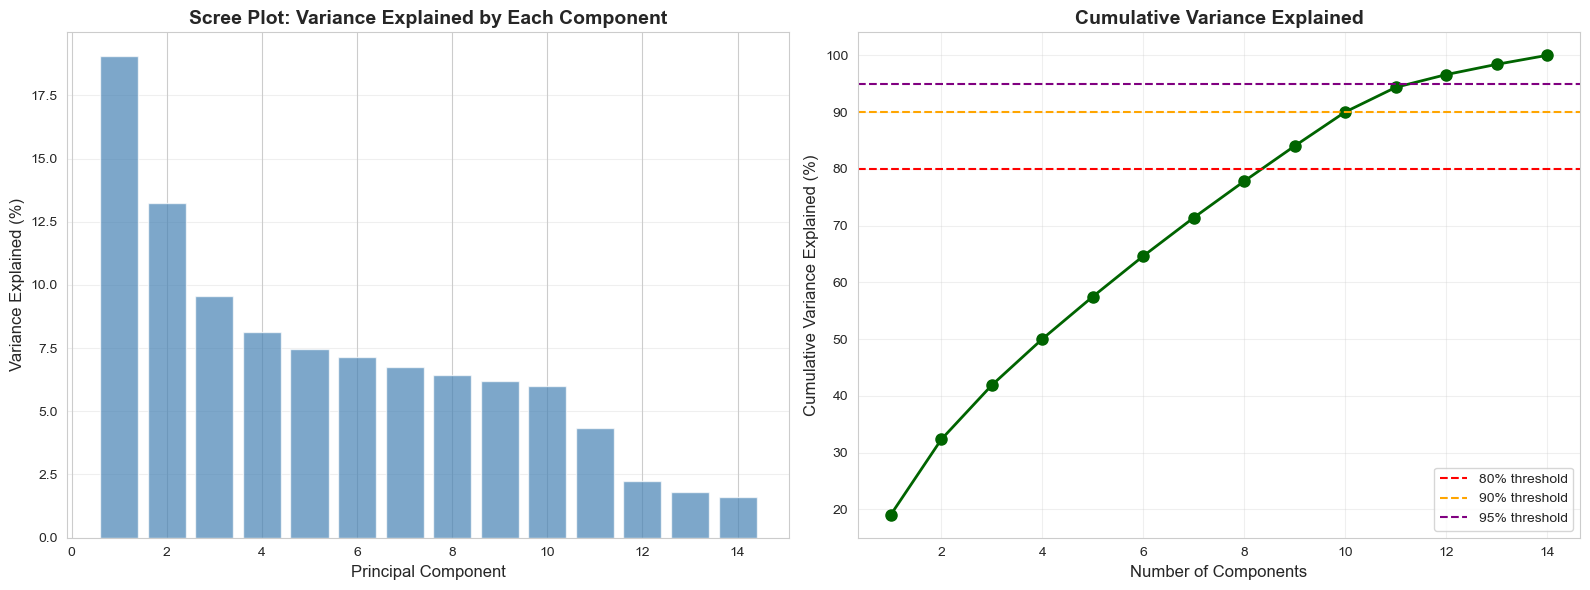


Components Needed to Explain Variance:
80% variance: 9 components
85% variance: 10 components
90% variance: 10 components
95% variance: 12 components

Optimal number of components (90% variance): 10

Original features: 14
After PCA: 10 components
Dimensionality reduction: 28.6%

Top Contributing Features to First 3 Principal Components:

PC1 (explains 19.0% variance):
  Sonic_Cluster: 0.440
  Acousticness: 0.424
  Danceability: -0.412
  Energy: -0.366
  Loudness: -0.322

PC2 (explains 13.3% variance):
  Evo_Cluster_ID: 0.511
  Energy: -0.492
  Loudness: -0.390
  Danceability: 0.315
  Speechiness: 0.307

PC3 (explains 9.6% variance):
  Valence: 0.441
  Artist_Tier: -0.374
  Evo_Cluster_ID: 0.351
  Sonic_Cluster: 0.341
  Speechiness: -0.338

Saved: pca_transformer.pkl


In [10]:
print("STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)")

from sklearn.decomposition import PCA

# Perform PCA with all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\nTotal features: {len(X.columns)}")
print(f"Total variance explained by all components: {cumulative_variance[-1]*100:.2f}%")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scree plot (variance per component)
axes[0].bar(range(1, len(explained_variance)+1), explained_variance * 100, 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained (%)', fontsize=12)
axes[0].set_title('Scree Plot: Variance Explained by Each Component', 
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, 
             marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(y=80, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% threshold')
axes[1].axhline(y=95, color='purple', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine optimal number of components
print("\nComponents Needed to Explain Variance:")
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"{threshold*100:.0f}% variance: {n_components} components")

# Choose number of components (let's use 90% threshold)
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nOptimal number of components (90% variance): {optimal_components}")

# Apply PCA with optimal components
pca_optimal = PCA(n_components=optimal_components)
X_pca = pca_optimal.fit_transform(X_scaled)

print(f"\nOriginal features: {X.shape[1]}")
print(f"After PCA: {X_pca.shape[1]} components")
print(f"Dimensionality reduction: {(1 - X_pca.shape[1]/X.shape[1])*100:.1f}%")

# Feature importance (loading scores)
print("\nTop Contributing Features to First 3 Principal Components:")

loadings = pd.DataFrame(
    pca_optimal.components_.T,
    columns=[f'PC{i+1}' for i in range(optimal_components)],
    index=X.columns
)

for i in range(min(3, optimal_components)):
    pc = f'PC{i+1}'
    print(f"\n{pc} (explains {pca_optimal.explained_variance_ratio_[i]*100:.1f}% variance):")
    top_features = loadings[pc].abs().sort_values(ascending=False).head(5)
    for feature, loading in top_features.items():
        print(f"  {feature}: {loadings.loc[feature, pc]:.3f}")

# Save PCA transformer
with open('pca_transformer.pkl', 'wb') as f:
    pickle.dump(pca_optimal, f)
print("\nSaved: pca_transformer.pkl")

In [11]:
print("STEP 6: TRAIN-TEST SPLIT")

from sklearn.model_selection import train_test_split

# Split using original features
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Maintain class distribution
)

print(f"\nOriginal Features Split:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"  Split ratio: {(X_test.shape[0]/len(X))*100:.1f}% test")

# Check class distribution in train and test
print("\nClass Distribution in Train Set:")
train_counts = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_counts.items():
    category = label_encoder.classes_[idx]
    percent = (count / len(y_train)) * 100
    print(f"  {category}: {count:,} ({percent:.1f}%)")

print("\nClass Distribution in Test Set:")
test_counts = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_counts.items():
    category = label_encoder.classes_[idx]
    percent = (count / len(y_test)) * 100
    print(f"  {category}: {count:,} ({percent:.1f}%)")

# Also split PCA-transformed data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\nPCA Features Split:")
print(f"  Training set: {X_pca_train.shape[0]:,} samples, {X_pca_train.shape[1]} features")
print(f"  Test set: {X_pca_test.shape[0]:,} samples, {X_pca_test.shape[1]} features")

print("\nData split completed!")

STEP 6: TRAIN-TEST SPLIT

Original Features Split:
  Training set: 7,328 samples
  Test set: 1,833 samples
  Split ratio: 20.0% test

Class Distribution in Train Set:
  Brief Hit: 1,962 (26.8%)
  Flop: 1,426 (19.5%)
  Long-Term Hit: 2,897 (39.5%)
  Sustained Success: 1,043 (14.2%)

Class Distribution in Test Set:
  Brief Hit: 491 (26.8%)
  Flop: 357 (19.5%)
  Long-Term Hit: 724 (39.5%)
  Sustained Success: 261 (14.2%)

PCA Features Split:
  Training set: 7,328 samples, 10 features
  Test set: 1,833 samples, 10 features

Data split completed!


In [12]:
print("STEP 7: BUILDING CLASSIFICATION MODELS")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import time

print("MODEL 1: LOGISTIC REGRESSION")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
start_time = time.time()

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)
log_reg.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Calculate metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted')
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted')

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy_log_reg*100:.2f}%")
print(f"  Precision: {precision_log_reg*100:.2f}%")
print(f"  Recall: {recall_log_reg*100:.2f}%")
print(f"  F1-Score: {f1_log_reg*100:.2f}%")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_log_reg, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

STEP 7: BUILDING CLASSIFICATION MODELS
MODEL 1: LOGISTIC REGRESSION

Training Logistic Regression...
Training completed in 0.06 seconds

Performance Metrics:
  Accuracy: 48.45%
  Precision: 37.07%
  Recall: 48.45%
  F1-Score: 38.51%

Detailed Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.28      0.05      0.09       491
             Flop       0.43      0.84      0.57       357
    Long-Term Hit       0.54      0.78      0.64       724
Sustained Success       0.00      0.00      0.00       261

         accuracy                           0.48      1833
        macro avg       0.31      0.42      0.32      1833
     weighted avg       0.37      0.48      0.39      1833



In [14]:
print("MODEL 2: RANDOM FOREST")

from sklearn.ensemble import RandomForestClassifier

print("\nTraining Random Forest...")
start_time = time.time()

random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
random_forest.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_rf = random_forest.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy_rf*100:.2f}%")
print(f"  Precision: {precision_rf*100:.2f}%")
print(f"  Recall: {recall_rf*100:.2f}%")
print(f"  F1-Score: {f1_rf*100:.2f}%")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Feature Importance
print("\nTop 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': random_forest.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

MODEL 2: RANDOM FOREST

Training Random Forest...
Training completed in 0.14 seconds

Performance Metrics:
  Accuracy: 57.28%
  Precision: 61.14%
  Recall: 57.28%
  F1-Score: 50.94%

Detailed Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.69      0.30      0.42       491
             Flop       0.48      0.82      0.61       357
    Long-Term Hit       0.60      0.84      0.70       724
Sustained Success       0.67      0.01      0.02       261

         accuracy                           0.57      1833
        macro avg       0.61      0.49      0.44      1833
     weighted avg       0.61      0.57      0.51      1833


Top 10 Most Important Features:
            Feature  Importance
Performance_Cluster    0.382065
           Loudness    0.082407
        Speechiness    0.074461
            Valence    0.073565
       Danceability    0.072829
       Acousticness    0.070521
             Energy    0.068123
     Geo_Cluster_ID  

In [17]:
print("MODEL 3: XGBOOST")

from xgboost import XGBClassifier

print("\nTraining XGBoost...")
start_time = time.time()

xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgboost.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_xgb = xgboost.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy_xgb*100:.2f}%")
print(f"  Precision: {precision_xgb*100:.2f}%")
print(f"  Recall: {recall_xgb*100:.2f}%")
print(f"  F1-Score: {f1_xgb*100:.2f}%")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Feature Importance
print("\nTop 10 Most Important Features:")
xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgboost.feature_importances_
}).sort_values('Importance', ascending=False)

print(xgb_feature_importance.head(10).to_string(index=False))

MODEL 3: XGBOOST

Training XGBoost...
Training completed in 0.99 seconds

Performance Metrics:
  Accuracy: 56.19%
  Precision: 53.65%
  Recall: 56.19%
  F1-Score: 53.18%

Detailed Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.53      0.39      0.45       491
             Flop       0.50      0.68      0.58       357
    Long-Term Hit       0.63      0.78      0.70       724
Sustained Success       0.35      0.11      0.17       261

         accuracy                           0.56      1833
        macro avg       0.50      0.49      0.47      1833
     weighted avg       0.54      0.56      0.53      1833


Top 10 Most Important Features:
            Feature  Importance
Performance_Cluster    0.531392
     Geo_Cluster_ID    0.069005
  Collab_Cluster_ID    0.038651
   Temporal_Cluster    0.036689
        Artist_Tier    0.034645
           Loudness    0.033013
             Energy    0.032872
       Acousticness    0.032850
 

In [18]:
print("MODEL 4: SUPPORT VECTOR MACHINE (SVM)")

from sklearn.svm import SVC

print("\nTraining SVM...")
start_time = time.time()

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True  # Enable probability estimates
)
svm.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_svm = svm.predict(X_test)

# Calculate metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy_svm*100:.2f}%")
print(f"  Precision: {precision_svm*100:.2f}%")
print(f"  Recall: {recall_svm*100:.2f}%")
print(f"  F1-Score: {f1_svm*100:.2f}%")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

MODEL 4: SUPPORT VECTOR MACHINE (SVM)

Training SVM...
Training completed in 6.69 seconds

Performance Metrics:
  Accuracy: 51.06%
  Precision: 41.43%
  Recall: 51.06%
  F1-Score: 42.00%

Detailed Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.39      0.10      0.16       491
             Flop       0.46      0.85      0.60       357
    Long-Term Hit       0.55      0.81      0.66       724
Sustained Success       0.00      0.00      0.00       261

         accuracy                           0.51      1833
        macro avg       0.35      0.44      0.35      1833
     weighted avg       0.41      0.51      0.42      1833



In [19]:
print("MODEL 5: GRADIENT BOOSTING")

from sklearn.ensemble import GradientBoostingClassifier

print("\nTraining Gradient Boosting...")
start_time = time.time()

gradient_boost = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gradient_boost.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_gb = gradient_boost.predict(X_test)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy_gb*100:.2f}%")
print(f"  Precision: {precision_gb*100:.2f}%")
print(f"  Recall: {recall_gb*100:.2f}%")
print(f"  F1-Score: {f1_gb*100:.2f}%")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_gb, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

MODEL 5: GRADIENT BOOSTING

Training Gradient Boosting...
Training completed in 4.21 seconds

Performance Metrics:
  Accuracy: 56.08%
  Precision: 52.87%
  Recall: 56.08%
  F1-Score: 52.13%

Detailed Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.54      0.37      0.44       491
             Flop       0.49      0.73      0.59       357
    Long-Term Hit       0.63      0.79      0.70       724
Sustained Success       0.30      0.06      0.10       261

         accuracy                           0.56      1833
        macro avg       0.49      0.49      0.46      1833
     weighted avg       0.53      0.56      0.52      1833



STEP 8: MODEL COMPARISON

MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision    Recall  F1-Score
Logistic Regression 48.445172  37.073316 48.445172 38.511643
      Random Forest 57.283142  61.139397 57.283142 50.935648
            XGBoost 56.192035  53.647178 56.192035 53.182790
                SVM 51.063830  41.432849 51.063830 42.001792
  Gradient Boosting 56.082924  52.869148 56.082924 52.127665


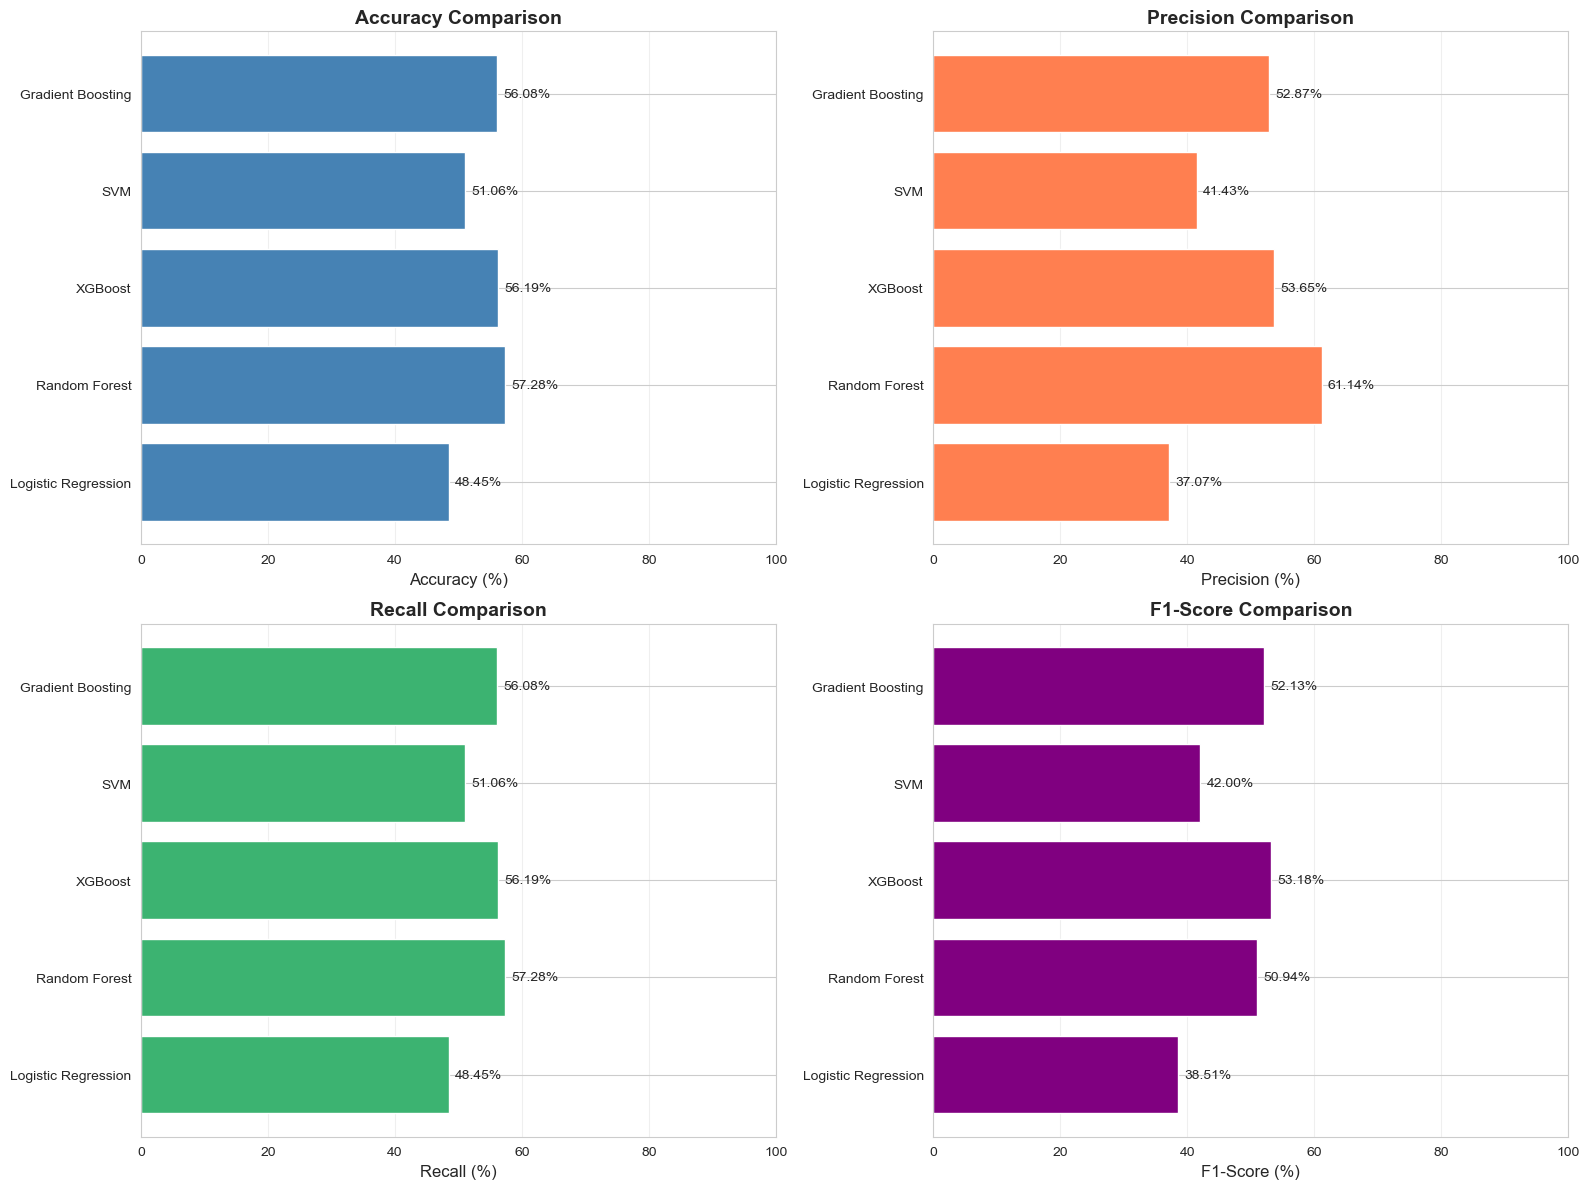

  BEST MODEL: XGBoost
   F1-Score: 53.18%


In [21]:
print("STEP 8: MODEL COMPARISON")

# Compile all results
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Gradient Boosting'],
    'Accuracy': [accuracy_log_reg, accuracy_rf, accuracy_xgb, accuracy_svm, accuracy_gb],
    'Precision': [precision_log_reg, precision_rf, precision_xgb, precision_svm, precision_gb],
    'Recall': [recall_log_reg, recall_rf, recall_xgb, recall_svm, recall_gb],
    'F1-Score': [f1_log_reg, f1_rf, f1_xgb, f1_svm, f1_gb]
})

# Convert to percentages
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    model_results[col] = model_results[col] * 100

print("\nMODEL PERFORMANCE COMPARISON:")
print("="*80)
print(model_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].barh(model_results['Model'], model_results[metric], color=color)
    axes[row, col].set_xlabel(f'{metric} (%)', fontsize=12)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (model, value) in enumerate(zip(model_results['Model'], model_results[metric])):
        axes[row, col].text(value + 1, i, f'{value:.2f}%', 
                           va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model_idx = model_results['F1-Score'].idxmax()
best_model_name = model_results.loc[best_model_idx, 'Model']
best_f1_score = model_results.loc[best_model_idx, 'F1-Score']

print(f"  BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1_score:.2f}%")

STEP 9: CONFUSION MATRICES VISUALIZATION


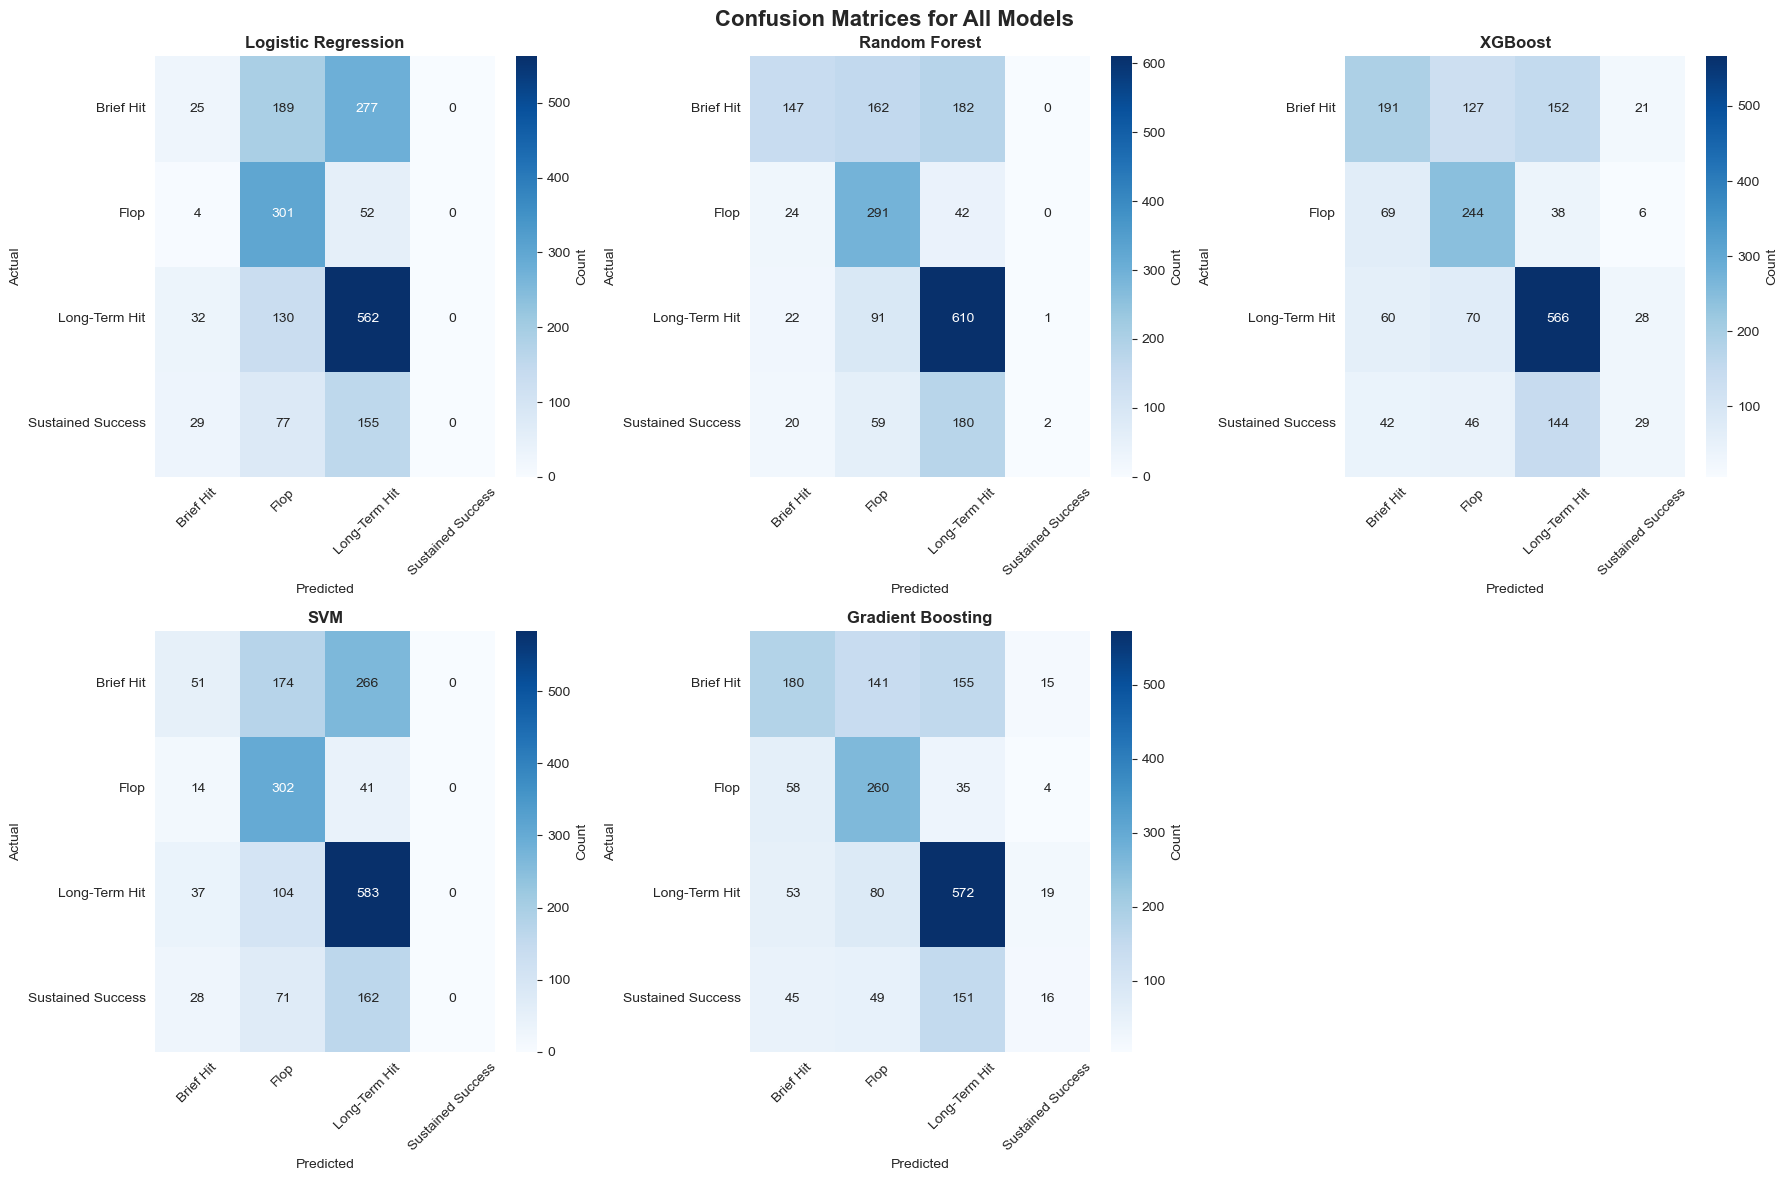

Confusion matrices visualized and saved!


In [22]:
print("STEP 9: CONFUSION MATRICES VISUALIZATION")

# Create confusion matrix plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

confusion_matrices = [
    (conf_matrix_log_reg, 'Logistic Regression', axes[0, 0]),
    (conf_matrix_rf, 'Random Forest', axes[0, 1]),
    (conf_matrix_xgb, 'XGBoost', axes[0, 2]),
    (conf_matrix_svm, 'SVM', axes[1, 0]),
    (conf_matrix_gb, 'Gradient Boosting', axes[1, 1])
]

for conf_matrix, title, ax in confusion_matrices:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices visualized and saved!")

STEP 10: HYPERPARAMETER TUNING FOR BEST MODELS

Top 2 models for hyperparameter tuning:
            Model  F1-Score
          XGBoost 53.182790
Gradient Boosting 52.127665
TUNING XGBOOST

Defining parameter grid for XGBoost...
Parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [5, 10, 15]
  learning_rate: [0.01, 0.1, 0.2]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]

Total combinations to test: 108

⏳ Starting Grid Search for XGBoost (this may take a while)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Grid search completed in 64.71 seconds (1.1 minutes)

Best Parameters Found for XGBoost:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 100
  subsample: 0.8

Tuned XGBoost Performance:
  Original XGBoost F1-Score: 53.18%
  Tuned XGBoost F1-Score: 51.29%
  Improvement: -1.89 percentage points

Complete Metrics for Tuned XGBoost:
  Accuracy: 56.30%
  Precision: 53.64%
  Recall: 56.30%
  F1-Score: 51.29%

Tuned XGBoost Cl

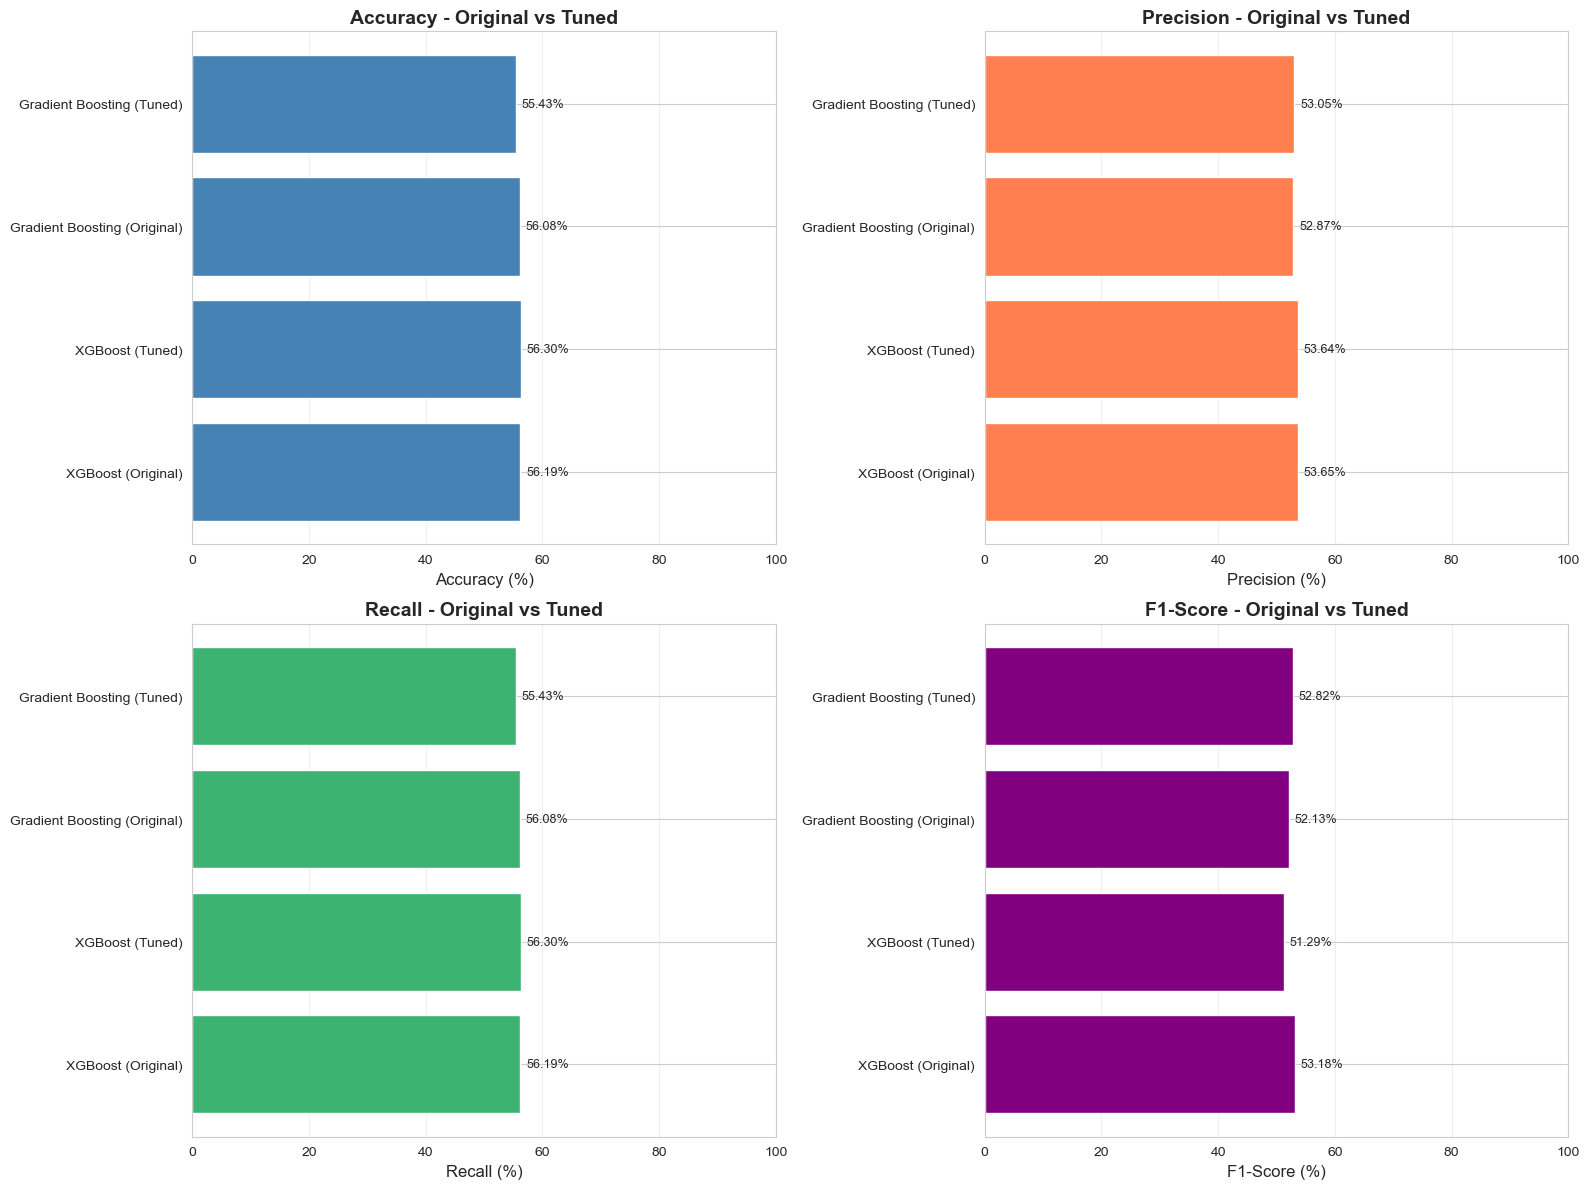


Improvement Summary:
XGBoost improvement: -1.89 percentage points
Gradient Boosting improvement: 0.69 percentage points
ABSOLUTE BEST MODEL: Tuned Gradient Boosting
F1-Score: 52.82%
Accuracy: 55.43%
Precision: 53.05%
Recall: 55.43%

Best Hyperparameters:
  learning_rate: 0.2
  max_depth: 5
  min_samples_leaf: 5
  min_samples_split: 20
  n_estimators: 100
  subsample: 1.0

Creating confusion matrix comparison...


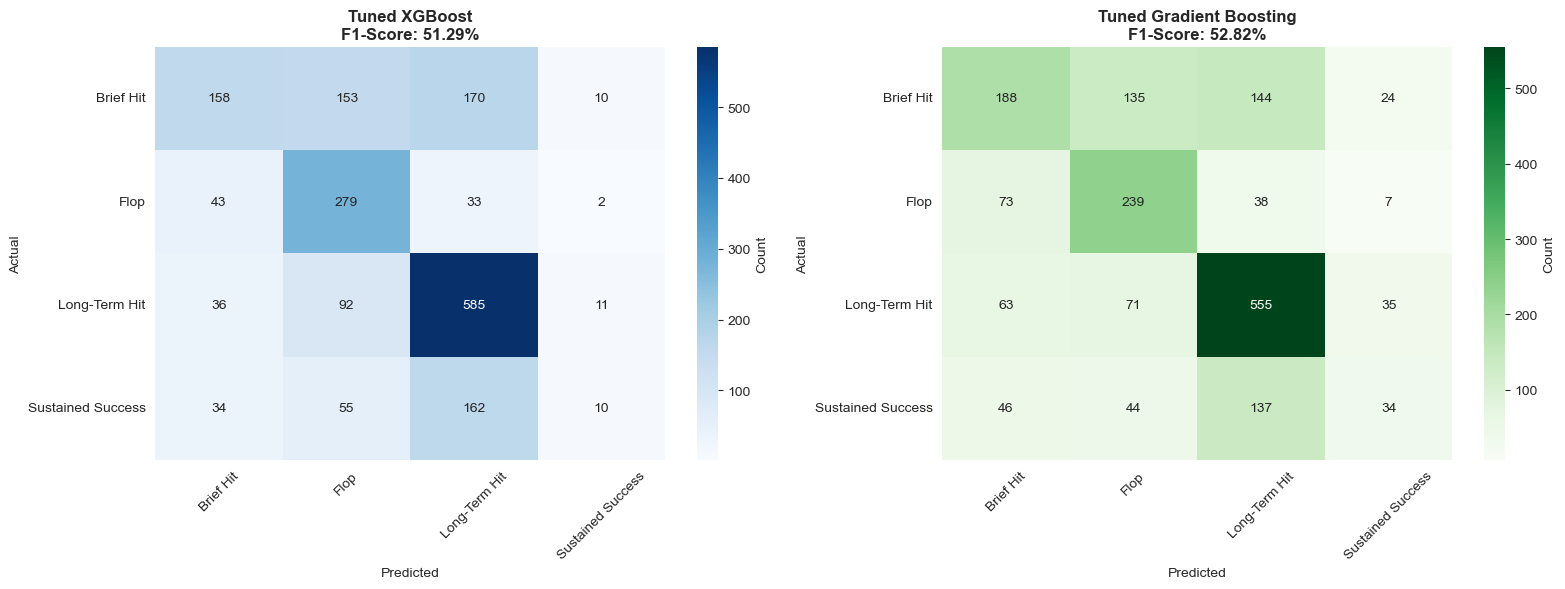


Hyperparameter tuning complete!
Best model identified: Tuned Gradient Boosting


In [24]:
print("STEP 10: HYPERPARAMETER TUNING FOR BEST MODELS")

# Based on results, tune the top 2 models: XGBoost and Gradient Boosting
from sklearn.model_selection import GridSearchCV

print("\nTop 2 models for hyperparameter tuning:")
top_2_models = model_results.nlargest(2, 'F1-Score')
print(top_2_models[['Model', 'F1-Score']].to_string(index=False))

print("TUNING XGBOOST")

print("\nDefining parameter grid for XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Parameter grid:")
for param, values in xgb_param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in xgb_param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

print("\n⏳ Starting Grid Search for XGBoost (this may take a while)...")
start_time = time.time()

xgb_grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
    xgb_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
print(f"\nGrid search completed in {tuning_time:.2f} seconds ({tuning_time/60:.1f} minutes)")

# Best parameters
print("\nBest Parameters Found for XGBoost:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned XGBoost
y_pred_xgb_tuned = xgb_grid_search.predict(X_test)

accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average='weighted')
precision_xgb_tuned = precision_score(y_test, y_pred_xgb_tuned, average='weighted')
recall_xgb_tuned = recall_score(y_test, y_pred_xgb_tuned, average='weighted')

print("\nTuned XGBoost Performance:")
print(f"  Original XGBoost F1-Score: {f1_xgb*100:.2f}%")
print(f"  Tuned XGBoost F1-Score: {f1_xgb_tuned*100:.2f}%")
print(f"  Improvement: {(f1_xgb_tuned - f1_xgb)*100:.2f} percentage points")

print("\nComplete Metrics for Tuned XGBoost:")
print(f"  Accuracy: {accuracy_xgb_tuned*100:.2f}%")
print(f"  Precision: {precision_xgb_tuned*100:.2f}%")
print(f"  Recall: {recall_xgb_tuned*100:.2f}%")
print(f"  F1-Score: {f1_xgb_tuned*100:.2f}%")

print("\nTuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned, 
                          target_names=label_encoder.classes_))

# Confusion matrix for tuned XGBoost
conf_matrix_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)

print("TUNING GRADIENT BOOSTING")

print("\nDefining parameter grid for Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

print("Parameter grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in gb_param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

print("\nStarting Grid Search for Gradient Boosting...")
start_time = time.time()

gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
print(f"\nGrid search completed in {tuning_time:.2f} seconds ({tuning_time/60:.1f} minutes)")

# Best parameters
print("\nBest Parameters Found for Gradient Boosting:")
for param, value in gb_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate tuned Gradient Boosting
y_pred_gb_tuned = gb_grid_search.predict(X_test)

accuracy_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
f1_gb_tuned = f1_score(y_test, y_pred_gb_tuned, average='weighted')
precision_gb_tuned = precision_score(y_test, y_pred_gb_tuned, average='weighted')
recall_gb_tuned = recall_score(y_test, y_pred_gb_tuned, average='weighted')

print("\nTuned Gradient Boosting Performance:")
print(f"  Original Gradient Boosting F1-Score: {f1_gb*100:.2f}%")
print(f"  Tuned Gradient Boosting F1-Score: {f1_gb_tuned*100:.2f}%")
print(f"  Improvement: {(f1_gb_tuned - f1_gb)*100:.2f} percentage points")

print("\nComplete Metrics for Tuned Gradient Boosting:")
print(f"  Accuracy: {accuracy_gb_tuned*100:.2f}%")
print(f"  Precision: {precision_gb_tuned*100:.2f}%")
print(f"  Recall: {recall_gb_tuned*100:.2f}%")
print(f"  F1-Score: {f1_gb_tuned*100:.2f}%")

print("\nTuned Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb_tuned, 
                          target_names=label_encoder.classes_))

# Confusion matrix for tuned Gradient Boosting
conf_matrix_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)

# COMPARE ALL TUNED MODELS
print("COMPARISON: ORIGINAL VS TUNED MODELS")

# Create comparison dataframe
tuning_comparison = pd.DataFrame({
    'Model': [
        'XGBoost (Original)',
        'XGBoost (Tuned)',
        'Gradient Boosting (Original)',
        'Gradient Boosting (Tuned)'
    ],
    'Accuracy': [
        accuracy_xgb * 100,
        accuracy_xgb_tuned * 100,
        accuracy_gb * 100,
        accuracy_gb_tuned * 100
    ],
    'Precision': [
        precision_xgb * 100,
        precision_xgb_tuned * 100,
        precision_gb * 100,
        precision_gb_tuned * 100
    ],
    'Recall': [
        recall_xgb * 100,
        recall_xgb_tuned * 100,
        recall_gb * 100,
        recall_gb_tuned * 100
    ],
    'F1-Score': [
        f1_xgb * 100,
        f1_xgb_tuned * 100,
        f1_gb * 100,
        f1_gb_tuned * 100
    ]
})

print("\nPerformance Comparison:")
print(tuning_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].barh(tuning_comparison['Model'], tuning_comparison[metric], color=color)
    axes[row, col].set_xlabel(f'{metric} (%)', fontsize=12)
    axes[row, col].set_title(f'{metric} - Original vs Tuned', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (model, value) in enumerate(zip(tuning_comparison['Model'], tuning_comparison[metric])):
        axes[row, col].text(value + 1, i, f'{value:.2f}%', 
                           va='center', fontsize=9)

plt.tight_layout()
plt.savefig('tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate improvements
xgb_improvement = (f1_xgb_tuned - f1_xgb) * 100
gb_improvement = (f1_gb_tuned - f1_gb) * 100

print("\nImprovement Summary:")
print(f"XGBoost improvement: {xgb_improvement:.2f} percentage points")
print(f"Gradient Boosting improvement: {gb_improvement:.2f} percentage points")

# Determine absolute best model
if f1_xgb_tuned > f1_gb_tuned:
    absolute_best_model = xgb_grid_search.best_estimator_
    absolute_best_name = 'Tuned XGBoost'
    absolute_best_f1 = f1_xgb_tuned
    absolute_best_params = xgb_grid_search.best_params_
    absolute_best_predictions = y_pred_xgb_tuned
    absolute_best_conf_matrix = conf_matrix_xgb_tuned
else:
    absolute_best_model = gb_grid_search.best_estimator_
    absolute_best_name = 'Tuned Gradient Boosting'
    absolute_best_f1 = f1_gb_tuned
    absolute_best_params = gb_grid_search.best_params_
    absolute_best_predictions = y_pred_gb_tuned
    absolute_best_conf_matrix = conf_matrix_gb_tuned

print(f"ABSOLUTE BEST MODEL: {absolute_best_name}")
print(f"F1-Score: {absolute_best_f1*100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, absolute_best_predictions)*100:.2f}%")
print(f"Precision: {precision_score(y_test, absolute_best_predictions, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_test, absolute_best_predictions, average='weighted')*100:.2f}%")

print("\nBest Hyperparameters:")
for param, value in absolute_best_params.items():
    print(f"  {param}: {value}")

# Visualize confusion matrices for both tuned models
print("\nCreating confusion matrix comparison...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Tuned XGBoost confusion matrix
sns.heatmap(conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Tuned XGBoost\nF1-Score: {f1_xgb_tuned*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=10)
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Tuned Gradient Boosting confusion matrix
sns.heatmap(conf_matrix_gb_tuned, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Tuned Gradient Boosting\nF1-Score: {f1_gb_tuned*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=10)
axes[1].set_ylabel('Actual', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('tuned_models_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHyperparameter tuning complete!")
print(f"Best model identified: {absolute_best_name}")

STEP 11: FINAL MODEL SELECTION

COMPLETE MODEL COMPARISON (ALL MODELS):
                       Model  Accuracy  Precision    Recall  F1-Score
          XGBoost (Original) 56.192035  53.647178 56.192035 53.182790
   Gradient Boosting (Tuned) 55.428260  53.052593 55.428260 52.820334
Gradient Boosting (Original) 56.082924  52.869148 56.082924 52.127665
             XGBoost (Tuned) 56.301146  53.639611 56.301146 51.294071
               Random Forest 57.283142  61.139397 57.283142 50.935648
                         SVM 51.063830  41.432849 51.063830 42.001792
         Logistic Regression 48.445172  37.073316 48.445172 38.511643
BEST MODEL IDENTIFIED: XGBoost (Original)
   F1-Score: 53.18%

Final Model Performance:
Accuracy:  56.19%
Precision: 53.65%
Recall:    56.19%
F1-Score:  53.18%

Note: This is an original (untuned) model
The tuning did not improve performance, so we're using the baseline model.

Detailed Classification Report:
                   precision    recall  f1-score   suppor

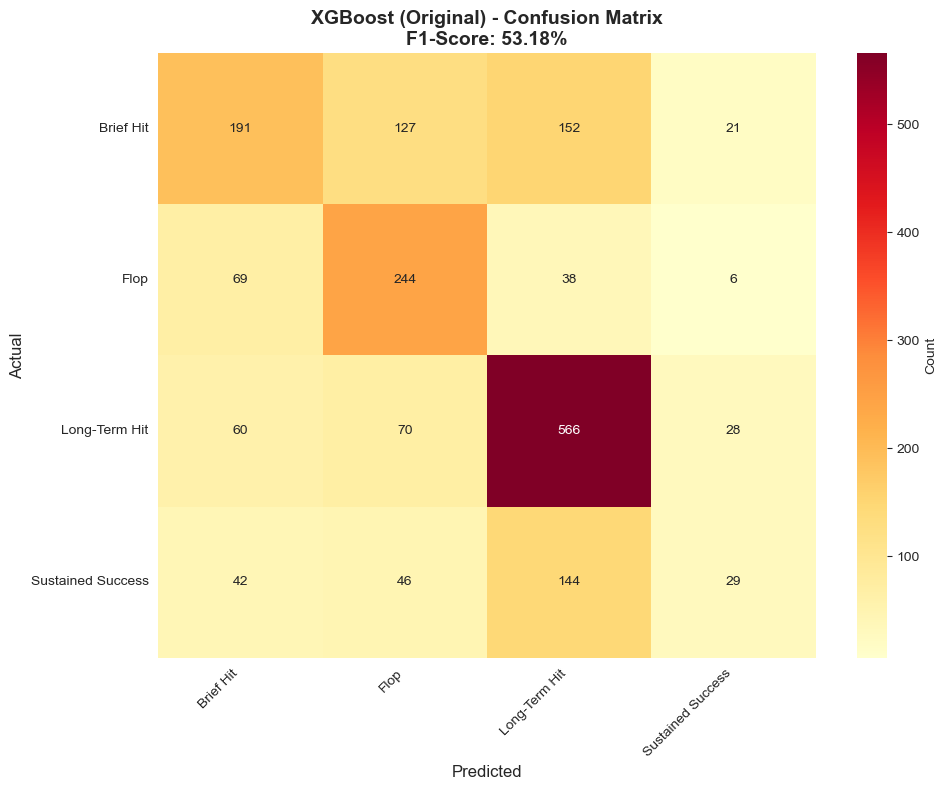

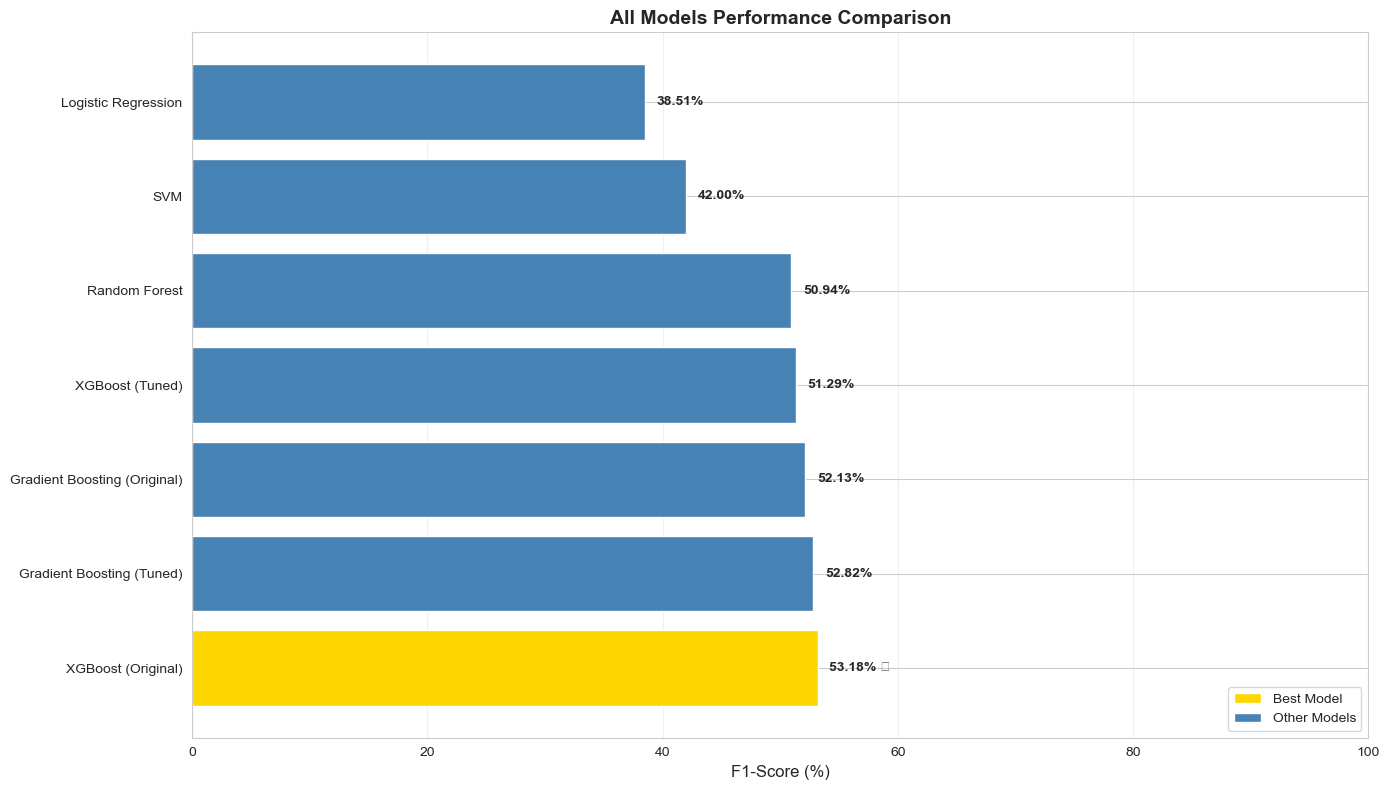


Saving final model and metadata...
Saved: final_model.pkl
Saved: model_metadata.json
Saved: all_models_comparison.csv
KEY INSIGHTS FROM MODEL SELECTION:

XGBoost Analysis:
   Original F1-Score: 53.18%
   Tuned F1-Score: 51.29%
   Change: -1.89 percentage points
   Tuning did not improve XGBoost (original may be already well-optimized)

Gradient Boosting Analysis:
   Original F1-Score: 52.13%
   Tuned F1-Score: 52.82%
   Change: +0.69 percentage points
   Tuning improved Gradient Boosting performance

Overall Analysis:
   Best Model: XGBoost (Original) (53.18%)
   Worst Model: Logistic Regression (38.51%)
   Performance Range: 14.67 percentage points
FINAL MODEL SELECTION COMPLETE!


In [27]:
print("STEP 11: FINAL MODEL SELECTION")

# Create comprehensive comparison of ALL models
all_models_comparison = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost (Original)',
        'XGBoost (Tuned)',
        'SVM',
        'Gradient Boosting (Original)',
        'Gradient Boosting (Tuned)'
    ],
    'Accuracy': [
        accuracy_log_reg * 100,
        accuracy_rf * 100,
        accuracy_xgb * 100,
        accuracy_xgb_tuned * 100,
        accuracy_svm * 100,
        accuracy_gb * 100,
        accuracy_gb_tuned * 100
    ],
    'Precision': [
        precision_log_reg * 100,
        precision_rf * 100,
        precision_xgb * 100,
        precision_xgb_tuned * 100,
        precision_svm * 100,
        precision_gb * 100,
        precision_gb_tuned * 100
    ],
    'Recall': [
        recall_log_reg * 100,
        recall_rf * 100,
        recall_xgb * 100,
        recall_xgb_tuned * 100,
        recall_svm * 100,
        recall_gb * 100,
        recall_gb_tuned * 100
    ],
    'F1-Score': [
        f1_log_reg * 100,
        f1_rf * 100,
        f1_xgb * 100,
        f1_xgb_tuned * 100,
        f1_svm * 100,
        f1_gb * 100,
        f1_gb_tuned * 100
    ]
})

# Sort by F1-Score
all_models_comparison = all_models_comparison.sort_values('F1-Score', ascending=False)

print("\nCOMPLETE MODEL COMPARISON (ALL MODELS):")
print(all_models_comparison.to_string(index=False))

# Find the absolute best model
best_idx = all_models_comparison['F1-Score'].idxmax()
best_model_name_final = all_models_comparison.loc[best_idx, 'Model']
best_f1_final = all_models_comparison.loc[best_idx, 'F1-Score']

print(f"BEST MODEL IDENTIFIED: {best_model_name_final}")
print(f"   F1-Score: {best_f1_final:.2f}%")

# Map model name to actual model object and predictions
model_mapping = {
    'Logistic Regression': {
        'model': log_reg,
        'predictions': y_pred_log_reg,
        'conf_matrix': conf_matrix_log_reg,
        'params': None
    },
    'Random Forest': {
        'model': random_forest,
        'predictions': y_pred_rf,
        'conf_matrix': conf_matrix_rf,
        'params': None
    },
    'XGBoost (Original)': {
        'model': xgboost,
        'predictions': y_pred_xgb,
        'conf_matrix': conf_matrix_xgb,
        'params': None
    },
    'XGBoost (Tuned)': {
        'model': xgb_grid_search.best_estimator_,
        'predictions': y_pred_xgb_tuned,
        'conf_matrix': conf_matrix_xgb_tuned,
        'params': xgb_grid_search.best_params_
    },
    'SVM': {
        'model': svm,
        'predictions': y_pred_svm,
        'conf_matrix': conf_matrix_svm,
        'params': None
    },
    'Gradient Boosting (Original)': {
        'model': gradient_boost,
        'predictions': y_pred_gb,
        'conf_matrix': conf_matrix_gb,
        'params': None
    },
    'Gradient Boosting (Tuned)': {
        'model': gb_grid_search.best_estimator_,
        'predictions': y_pred_gb_tuned,
        'conf_matrix': conf_matrix_gb_tuned,
        'params': gb_grid_search.best_params_
    }
}

# Get the final model details
final_model = model_mapping[best_model_name_final]['model']
y_pred_final = model_mapping[best_model_name_final]['predictions']
final_conf_matrix = model_mapping[best_model_name_final]['conf_matrix']
final_params = model_mapping[best_model_name_final]['params']

# Print detailed results
print("\nFinal Model Performance:")
best_row = all_models_comparison[all_models_comparison['Model'] == best_model_name_final].iloc[0]
print(f"Accuracy:  {best_row['Accuracy']:.2f}%")
print(f"Precision: {best_row['Precision']:.2f}%")
print(f"Recall:    {best_row['Recall']:.2f}%")
print(f"F1-Score:  {best_row['F1-Score']:.2f}%")

if final_params is not None:
    print("\nHyperparameters:")
    for param, value in final_params.items():
        print(f"  {param}: {value}")
else:
    print("\nNote: This is an original (untuned) model")
    print("The tuning did not improve performance, so we're using the baseline model.")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final, 
                          target_names=label_encoder.classes_))

# Visualize final confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{best_model_name_final} - Confusion Matrix\nF1-Score: {best_f1_final:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('final_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Create comparison visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Create bar chart
models = all_models_comparison['Model']
f1_scores = all_models_comparison['F1-Score']

# Color the best model differently
colors = ['gold' if model == best_model_name_final else 'steelblue' for model in models]

bars = ax.barh(range(len(models)), f1_scores, color=colors)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel('F1-Score (%)', fontsize=12)
ax.set_title('All Models Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (model, f1) in enumerate(zip(models, f1_scores)):
    label = f'{f1:.2f}%'
    if model == best_model_name_final:
        label += ' 🏆'
    ax.text(f1 + 1, i, label, va='center', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gold', label='Best Model'),
    Patch(facecolor='steelblue', label='Other Models')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('all_models_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
print("\nSaving final model and metadata...")
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("Saved: final_model.pkl")

# Determine model type
model_type = 'Unknown'
if 'Logistic' in best_model_name_final:
    model_type = 'Logistic Regression'
elif 'Random Forest' in best_model_name_final:
    model_type = 'Random Forest'
elif 'XGBoost' in best_model_name_final:
    model_type = 'XGBoost'
elif 'SVM' in best_model_name_final:
    model_type = 'Support Vector Machine'
elif 'Gradient Boosting' in best_model_name_final:
    model_type = 'Gradient Boosting'

# Save model metadata
model_metadata = {
    'model_name': best_model_name_final,
    'model_type': model_type,
    'is_tuned': 'Tuned' in best_model_name_final,
    'hyperparameters': final_params if final_params else 'Default/Original',
    'performance_metrics': {
        'f1_score': float(best_f1_final / 100),
        'accuracy': float(best_row['Accuracy'] / 100),
        'precision': float(best_row['Precision'] / 100),
        'recall': float(best_row['Recall'] / 100)
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_used': list(X.columns),
    'num_features': len(X.columns),
    'target_classes': list(label_encoder.classes_),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'note': 'Selected as best performing model from all candidates (original and tuned)'
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
print("Saved: model_metadata.json")

# Save comparison table
all_models_comparison.to_csv('all_models_comparison.csv', index=False)
print("Saved: all_models_comparison.csv")

print("KEY INSIGHTS FROM MODEL SELECTION:")

# Compare tuned vs original
if 'XGBoost' in best_model_name_final:
    xgb_orig_f1 = all_models_comparison[all_models_comparison['Model'] == 'XGBoost (Original)']['F1-Score'].values[0]
    xgb_tuned_f1 = all_models_comparison[all_models_comparison['Model'] == 'XGBoost (Tuned)']['F1-Score'].values[0]
    xgb_improvement = xgb_tuned_f1 - xgb_orig_f1
    
    print(f"\nXGBoost Analysis:")
    print(f"   Original F1-Score: {xgb_orig_f1:.2f}%")
    print(f"   Tuned F1-Score: {xgb_tuned_f1:.2f}%")
    print(f"   Change: {xgb_improvement:+.2f} percentage points")
    if xgb_improvement > 0:
        print(f"   Tuning improved XGBoost performance")
    else:
        print(f"   Tuning did not improve XGBoost (original may be already well-optimized)")

gb_orig_f1 = all_models_comparison[all_models_comparison['Model'] == 'Gradient Boosting (Original)']['F1-Score'].values[0]
gb_tuned_f1 = all_models_comparison[all_models_comparison['Model'] == 'Gradient Boosting (Tuned)']['F1-Score'].values[0]
gb_improvement = gb_tuned_f1 - gb_orig_f1

print(f"\nGradient Boosting Analysis:")
print(f"   Original F1-Score: {gb_orig_f1:.2f}%")
print(f"   Tuned F1-Score: {gb_tuned_f1:.2f}%")
print(f"   Change: {gb_improvement:+.2f} percentage points")
if gb_improvement > 0:
    print(f"   Tuning improved Gradient Boosting performance")
else:
    print(f"   Tuning degraded Gradient Boosting performance (original was better)")
    print(f"   This can happen due to overfitting or suboptimal hyperparameter search space")

# Overall best
worst_f1 = all_models_comparison['F1-Score'].min()
performance_range = best_f1_final - worst_f1

print(f"\nOverall Analysis:")
print(f"   Best Model: {best_model_name_final} ({best_f1_final:.2f}%)")
print(f"   Worst Model: {all_models_comparison.iloc[-1]['Model']} ({worst_f1:.2f}%)")
print(f"   Performance Range: {performance_range:.2f} percentage points")

print("FINAL MODEL SELECTION COMPLETE!")

STEP 12: FEATURE IMPORTANCE ANALYSIS FOR FINAL MODEL

Analyzing feature importance for: XGBoost (Original)

Top 15 Most Important Features:
            Feature  Importance
Performance_Cluster    0.531392
     Geo_Cluster_ID    0.069005
  Collab_Cluster_ID    0.038651
   Temporal_Cluster    0.036689
        Artist_Tier    0.034645
           Loudness    0.033013
             Energy    0.032872
       Acousticness    0.032850
       Danceability    0.032619
            Valence    0.032436
        Speechiness    0.032229
      Sonic_Cluster    0.031823
     Evo_Cluster_ID    0.031127
   Instrumentalness    0.030649


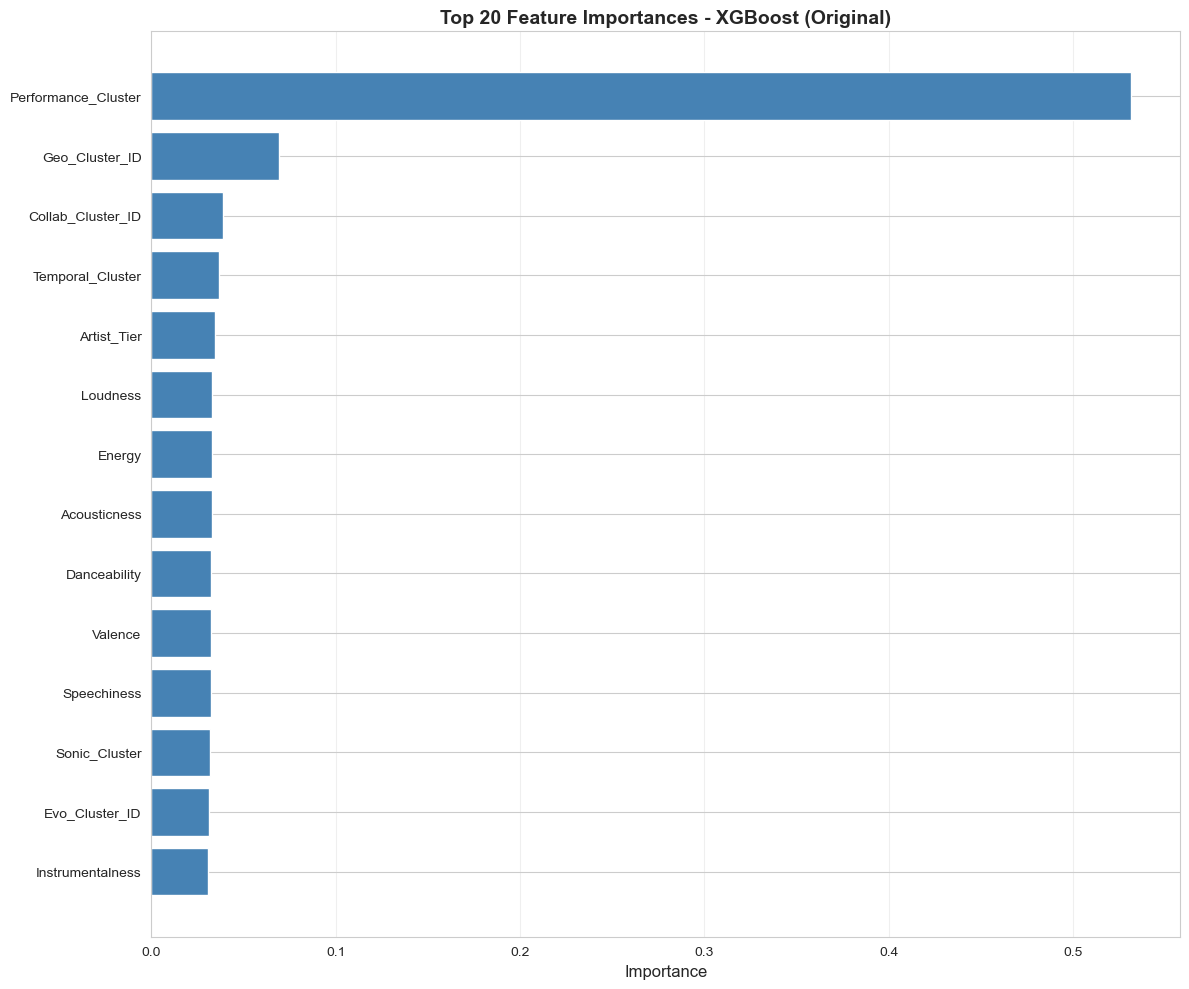


Saved: feature_importance.csv

Feature Type Importance Breakdown:
Cluster Meta-Features:
  Number of features: 7
  Total importance: 0.7733
  Percentage: 77.3%
  Average importance: 0.1105

Original Audio Features:
  Number of features: 7
  Total importance: 0.2267
  Percentage: 22.7%
  Average importance: 0.0324


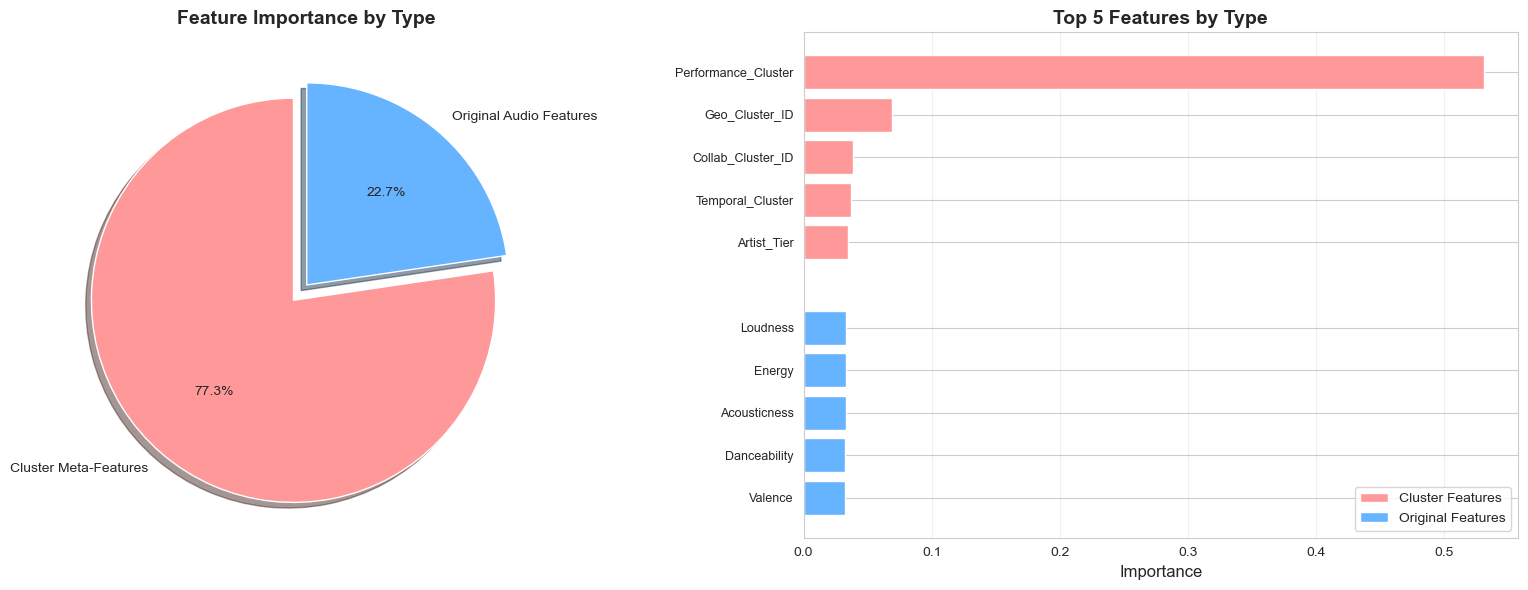


Top 5 Cluster Meta-Features:
  Performance_Cluster: 0.5314
  Geo_Cluster_ID: 0.0690
  Collab_Cluster_ID: 0.0387
  Temporal_Cluster: 0.0367
  Artist_Tier: 0.0346

Top 5 Original Audio Features:
  Loudness: 0.0330
  Energy: 0.0329
  Acousticness: 0.0328
  Danceability: 0.0326
  Valence: 0.0324

Feature importance analysis complete


In [29]:
print("STEP 12: FEATURE IMPORTANCE ANALYSIS FOR FINAL MODEL")

print(f"\nAnalyzing feature importance for: {best_model_name_final}")

# Get feature importance from final model
if hasattr(final_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance_final.head(15).to_string(index=False))
    
    # Visualize top 20 features
    plt.figure(figsize=(12, 10))
    top_20 = feature_importance_final.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'].values, color='steelblue')
    plt.yticks(range(len(top_20)), top_20['Feature'].values)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name_final}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance_final_model.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance
    feature_importance_final.to_csv('feature_importance.csv', index=False)
    print("\nSaved: feature_importance.csv")
    
    # Analyze cluster vs original features
    cluster_features = []
    original_features_list = []
    
    for feature in feature_importance_final['Feature']:
        if any(x in feature for x in ['Cluster', 'Tier', '_ID']):
            cluster_features.append(feature)
        else:
            original_features_list.append(feature)
    
    cluster_importance = feature_importance_final[
        feature_importance_final['Feature'].isin(cluster_features)
    ]['Importance'].sum()
    
    original_importance = feature_importance_final[
        feature_importance_final['Feature'].isin(original_features_list)
    ]['Importance'].sum()
    
    total_importance = cluster_importance + original_importance
    
    print("\nFeature Type Importance Breakdown:")
    print(f"Cluster Meta-Features:")
    print(f"  Number of features: {len(cluster_features)}")
    print(f"  Total importance: {cluster_importance:.4f}")
    print(f"  Percentage: {(cluster_importance/total_importance)*100:.1f}%")
    print(f"  Average importance: {cluster_importance/len(cluster_features):.4f}")
    
    print(f"\nOriginal Audio Features:")
    print(f"  Number of features: {len(original_features_list)}")
    print(f"  Total importance: {original_importance:.4f}")
    print(f"  Percentage: {(original_importance/total_importance)*100:.1f}%")
    print(f"  Average importance: {original_importance/len(original_features_list):.4f}")
    
    # Create pie chart
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart of importance by type
    labels = ['Cluster Meta-Features', 'Original Audio Features']
    sizes = [cluster_importance, original_importance]
    colors = ['#ff9999', '#66b3ff']
    explode = (0.1, 0)
    
    axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
    axes[0].set_title('Feature Importance by Type', fontsize=14, fontweight='bold')
    
    # Bar chart of top features by type
    top_cluster = feature_importance_final[
        feature_importance_final['Feature'].isin(cluster_features)
    ].head(5)
    top_original = feature_importance_final[
        feature_importance_final['Feature'].isin(original_features_list)
    ].head(5)
    
    y_pos = list(range(len(top_cluster))) + [x + len(top_cluster) + 1 for x in range(len(top_original))]
    importance_values = list(top_cluster['Importance'].values) + list(top_original['Importance'].values)
    feature_names = list(top_cluster['Feature'].values) + list(top_original['Feature'].values)
    colors_bar = ['#ff9999'] * len(top_cluster) + ['#66b3ff'] * len(top_original)
    
    axes[1].barh(y_pos, importance_values, color=colors_bar)
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(feature_names, fontsize=9)
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title('Top 5 Features by Type', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff9999', label='Cluster Features'),
        Patch(facecolor='#66b3ff', label='Original Features')
    ]
    axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('feature_importance_by_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top features of each type
    print("\nTop 5 Cluster Meta-Features:")
    for idx, row in top_cluster.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    print("\nTop 5 Original Audio Features:")
    for idx, row in top_original.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
else:
    print("\nSelected model does not support feature importance extraction")
    print("(This is the case for SVM and Logistic Regression)")
    
    # Alternative: Use permutation importance
    from sklearn.inspection import permutation_importance
    
    print("\nComputing permutation importance (this may take a moment)...")
    perm_importance = permutation_importance(
        final_model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    feature_importance_final = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features (Permutation Importance):")
    print(feature_importance_final.head(15).to_string(index=False))
    
    feature_importance_final.to_csv('feature_importance.csv', index=False)
    print("\nSaved: feature_importance.csv")

print("\nFeature importance analysis complete")

STEP 13: MODEL INTERPRETATION & INSIGHTS

Analyzing predictions for: XGBoost (Original)

Per-Class Performance Analysis:

Brief Hit:
  Test samples: 491
  Correctly predicted: 191
  Accuracy: 38.90%
  Precision: 52.76%
  Recall: 38.90%
  F1-Score: 44.78%
  Most common misclassification: Long-Term Hit
    (152 cases, 31.0% of this class)

Flop:
  Test samples: 357
  Correctly predicted: 244
  Accuracy: 68.35%
  Precision: 50.10%
  Recall: 68.35%
  F1-Score: 57.82%
  Most common misclassification: Brief Hit
    (69 cases, 19.3% of this class)

Long-Term Hit:
  Test samples: 724
  Correctly predicted: 566
  Accuracy: 78.18%
  Precision: 62.89%
  Recall: 78.18%
  F1-Score: 69.70%
  Most common misclassification: Flop
    (70 cases, 9.7% of this class)

Sustained Success:
  Test samples: 261
  Correctly predicted: 29
  Accuracy: 11.11%
  Precision: 34.52%
  Recall: 11.11%
  F1-Score: 16.81%
  Most common misclassification: Long-Term Hit
    (144 cases, 55.2% of this class)


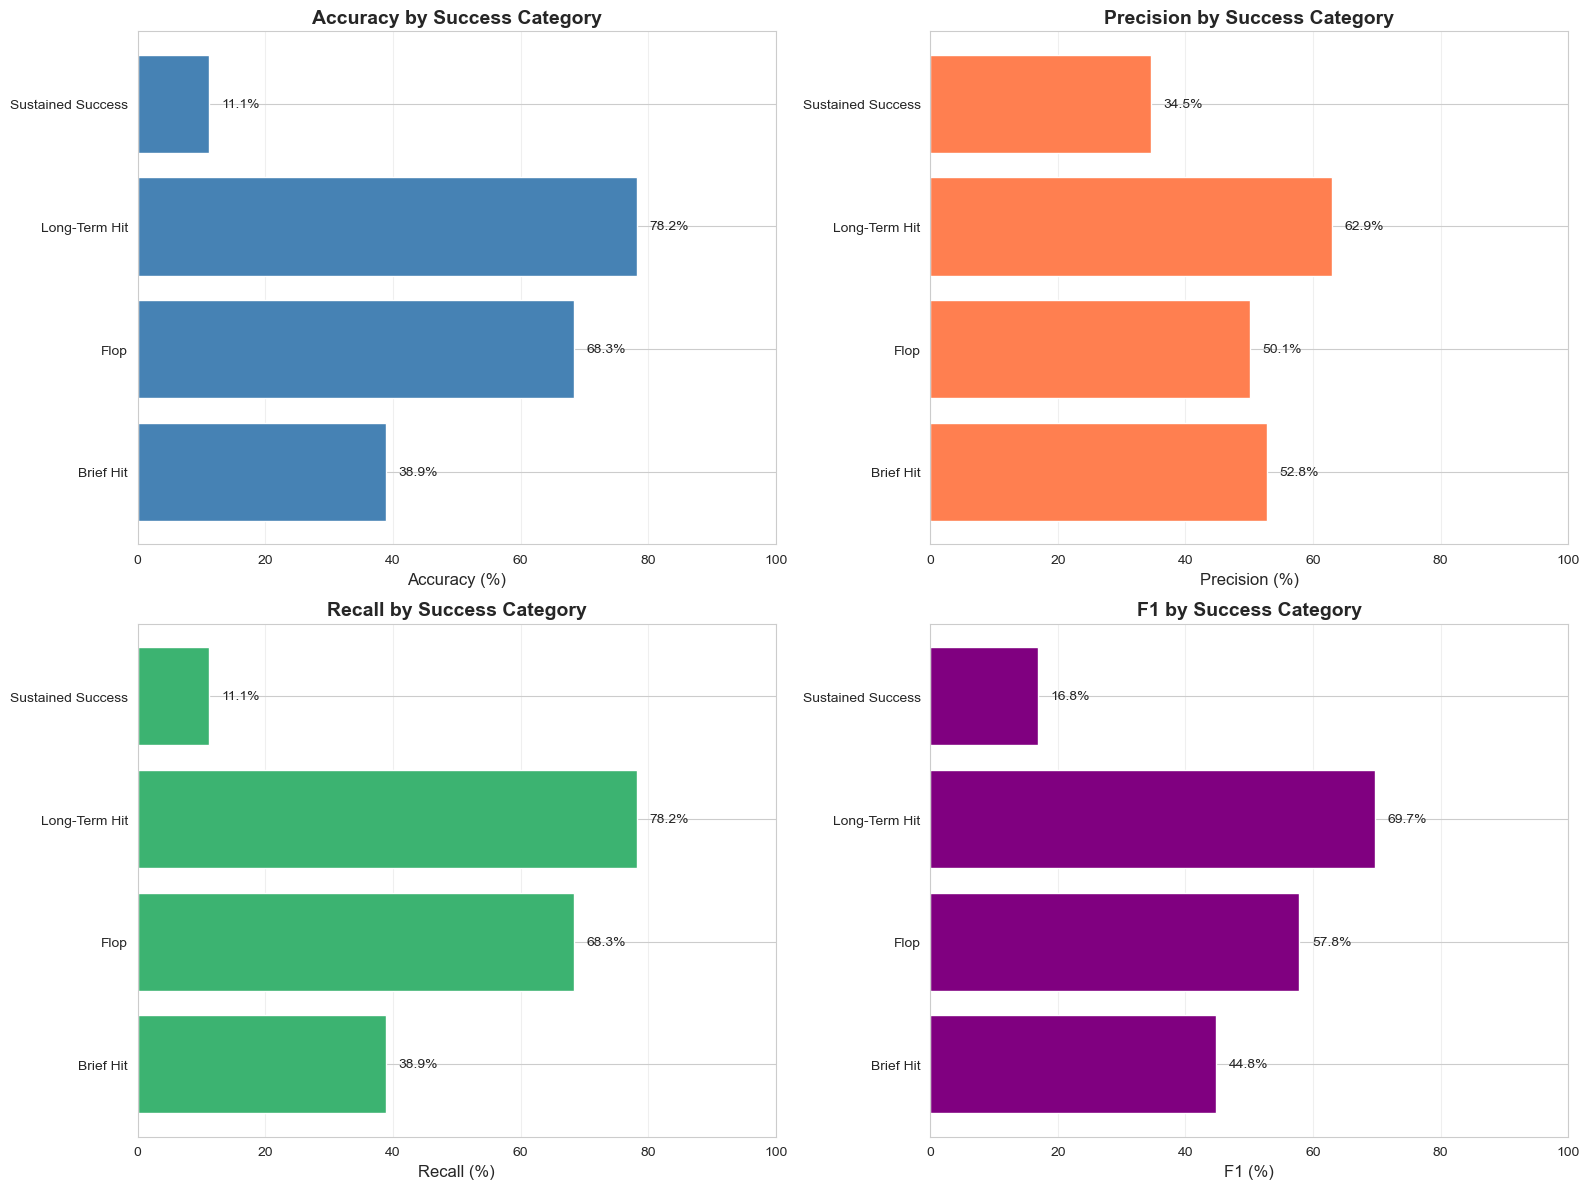


Saved: per_class_performance.csv
PREDICTION CONFIDENCE ANALYSIS:
Average confidence: 63.99%
Median confidence: 60.00%
Min confidence: 27.96%
Max confidence: 99.89%

Confidence Distribution:
  Very High (>90%): 298 (16.3%)
  High (80-90%): 144 (7.9%)
  Medium (60-80%): 475 (25.9%)
  Low (40-60%): 737 (40.2%)
  Very Low (<40%): 179 (9.8%)

Confidence by Correctness:
  Correct predictions: 70.54% average confidence
  Incorrect predictions: 55.59% average confidence
  Difference: 14.95 percentage points


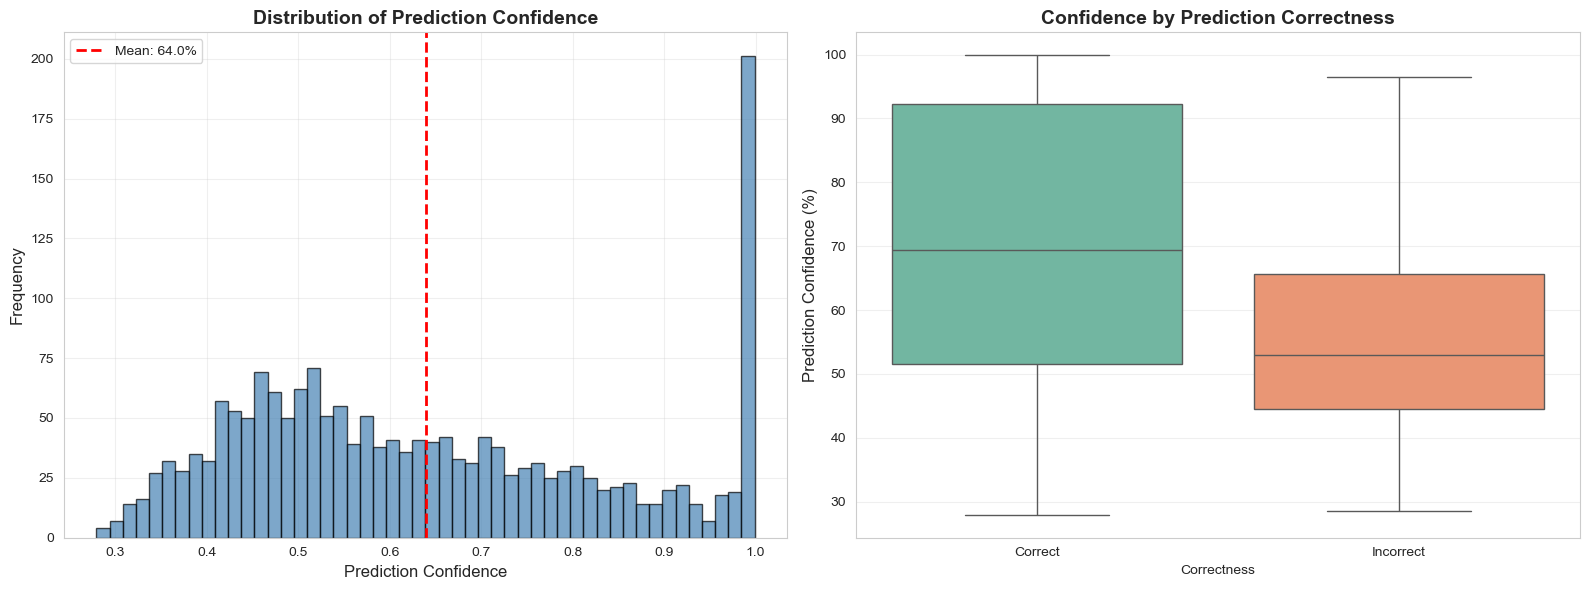


Model interpretation complete!


In [30]:
print("STEP 13: MODEL INTERPRETATION & INSIGHTS")

print(f"\nAnalyzing predictions for: {best_model_name_final}")

# Analyze predictions by success category
print("\nPer-Class Performance Analysis:")

class_performance = []

for class_idx, class_name in enumerate(label_encoder.classes_):
    # Get samples from this class
    class_mask = (y_test == class_idx)
    class_predictions = y_pred_final[class_mask]
    
    # Calculate metrics for this class
    correctly_predicted = (class_predictions == class_idx).sum()
    total_in_class = class_mask.sum()
    class_accuracy = correctly_predicted / total_in_class if total_in_class > 0 else 0
    
    # Calculate precision and recall for this class
    true_positives = correctly_predicted
    false_positives = ((y_pred_final == class_idx) & (y_test != class_idx)).sum()
    false_negatives = ((y_pred_final != class_idx) & (y_test == class_idx)).sum()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    class_performance.append({
        'Class': class_name,
        'Total_Samples': total_in_class,
        'Correct': correctly_predicted,
        'Accuracy': class_accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1': f1 * 100
    })
    
    print(f"\n{class_name}:")
    print(f"  Test samples: {total_in_class}")
    print(f"  Correctly predicted: {correctly_predicted}")
    print(f"  Accuracy: {class_accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall: {recall*100:.2f}%")
    print(f"  F1-Score: {f1*100:.2f}%")
    
    # Show most common misclassification
    if len(class_predictions) > 0:
        misclassified = class_predictions[class_predictions != class_idx]
        if len(misclassified) > 0:
            misclass_counts = pd.Series(misclassified).value_counts()
            most_common_error = misclass_counts.index[0]
            error_count = misclass_counts.values[0]
            error_pct = (error_count / total_in_class) * 100
            print(f"  Most common misclassification: {label_encoder.classes_[most_common_error]}")
            print(f"    ({error_count} cases, {error_pct:.1f}% of this class)")

# Create visualization of per-class performance
class_perf_df = pd.DataFrame(class_performance)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].barh(class_perf_df['Class'], class_perf_df[metric], color=color)
    axes[row, col].set_xlabel(f'{metric} (%)', fontsize=12)
    axes[row, col].set_title(f'{metric} by Success Category', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (cat, value) in enumerate(zip(class_perf_df['Class'], class_perf_df[metric])):
        axes[row, col].text(value + 2, i, f'{value:.1f}%', 
                           va='center', fontsize=10)

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save per-class performance
class_perf_df.to_csv('per_class_performance.csv', index=False)
print("\nSaved: per_class_performance.csv")

# Prediction confidence analysis (if model supports probability predictions)
if hasattr(final_model, 'predict_proba'):
    y_proba = final_model.predict_proba(X_test)
    
    # Calculate prediction confidence
    prediction_confidence = np.max(y_proba, axis=1)
    
    print("PREDICTION CONFIDENCE ANALYSIS:")
    print(f"Average confidence: {prediction_confidence.mean()*100:.2f}%")
    print(f"Median confidence: {np.median(prediction_confidence)*100:.2f}%")
    print(f"Min confidence: {prediction_confidence.min()*100:.2f}%")
    print(f"Max confidence: {prediction_confidence.max()*100:.2f}%")
    
    print(f"\nConfidence Distribution:")
    print(f"  Very High (>90%): {(prediction_confidence > 0.9).sum()} ({(prediction_confidence > 0.9).mean()*100:.1f}%)")
    print(f"  High (80-90%): {((prediction_confidence > 0.8) & (prediction_confidence <= 0.9)).sum()} ({((prediction_confidence > 0.8) & (prediction_confidence <= 0.9)).mean()*100:.1f}%)")
    print(f"  Medium (60-80%): {((prediction_confidence > 0.6) & (prediction_confidence <= 0.8)).sum()} ({((prediction_confidence > 0.6) & (prediction_confidence <= 0.8)).mean()*100:.1f}%)")
    print(f"  Low (40-60%): {((prediction_confidence > 0.4) & (prediction_confidence <= 0.6)).sum()} ({((prediction_confidence > 0.4) & (prediction_confidence <= 0.6)).mean()*100:.1f}%)")
    print(f"  Very Low (<40%): {(prediction_confidence <= 0.4).sum()} ({(prediction_confidence <= 0.4).mean()*100:.1f}%)")
    
    # Analyze confidence by correctness
    correct_predictions = (y_pred_final == y_test)
    correct_confidence = prediction_confidence[correct_predictions].mean()
    incorrect_confidence = prediction_confidence[~correct_predictions].mean()
    
    print(f"\nConfidence by Correctness:")
    print(f"  Correct predictions: {correct_confidence*100:.2f}% average confidence")
    print(f"  Incorrect predictions: {incorrect_confidence*100:.2f}% average confidence")
    print(f"  Difference: {(correct_confidence - incorrect_confidence)*100:.2f} percentage points")
    
    # Visualize confidence distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram of confidence
    axes[0].hist(prediction_confidence, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(prediction_confidence.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {prediction_confidence.mean()*100:.1f}%')
    axes[0].set_xlabel('Prediction Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot: confidence by correctness
    confidence_df = pd.DataFrame({
        'Confidence': prediction_confidence * 100,
        'Correctness': ['Correct' if c else 'Incorrect' for c in correct_predictions]
    })
    
    sns.boxplot(data=confidence_df, x='Correctness', y='Confidence', ax=axes[1], palette='Set2')
    axes[1].set_ylabel('Prediction Confidence (%)', fontsize=12)
    axes[1].set_title('Confidence by Prediction Correctness', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prediction_confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("\nModel does not support probability predictions")
    print("Skipping confidence analysis")

print("\nModel interpretation complete!")

In [31]:
print("DIAGNOSTIC ANALYSIS: WHY IS PERFORMANCE LOW?")

# 1. Check class imbalance
print("\nCLASS IMBALANCE CHECK:")

class_distribution = final_data['Success_Category'].value_counts()
print("\nClass Distribution:")
for category, count in class_distribution.items():
    percent = (count / len(final_data)) * 100
    print(f"  {category}: {count:,} ({percent:.1f}%)")

# Calculate imbalance ratio
max_class = class_distribution.max()
min_class = class_distribution.min()
imbalance_ratio = max_class / min_class

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("SEVERE CLASS IMBALANCE DETECTED")
    print("This is likely a major cause of low F1-score")
elif imbalance_ratio > 1.5:
    print("Moderate class imbalance detected")
else:
    print("Classes are relatively balanced")

# 2. Check per-class performance
print("PER-CLASS PERFORMANCE BREAKDOWN:")

# Recalculate with current model
y_pred_current = final_model.predict(X_test)

for class_idx, class_name in enumerate(label_encoder.classes_):
    class_mask = (y_test == class_idx)
    class_predictions = y_pred_current[class_mask]
    
    if len(class_predictions) > 0:
        class_accuracy = (class_predictions == class_idx).sum() / len(class_predictions)
        
        # Calculate F1 for this class
        from sklearn.metrics import f1_score
        class_f1 = f1_score(y_test == class_idx, y_pred_current == class_idx)
        
        print(f"\n{class_name}:")
        print(f"  Test samples: {class_mask.sum()}")
        print(f"  Accuracy: {class_accuracy*100:.2f}%")
        print(f"  F1-Score: {class_f1*100:.2f}%")
        
        if class_f1 < 0.4:
            print(f"  POOR PERFORMANCE - This class is dragging down overall F1")

# 3. Check feature separability
print("FEATURE SEPARABILITY CHECK:")

# For top 5 features, check how well they separate classes
if hasattr(final_model, 'feature_importances_'):
    top_5_features = feature_importance_final.head(5)['Feature'].values
    
    print("\nChecking if top features clearly separate classes...")
    for feature in top_5_features:
        print(f"\n{feature}:")
        for category in label_encoder.classes_:
            category_data = final_data[final_data['Success_Category'] == category][feature]
            print(f"  {category}: mean={category_data.mean():.3f}, std={category_data.std():.3f}")
    
    print("\nIf means are very similar across classes, features don't separate well")

# 4. Check if problem is too hard
print("PROBLEM DIFFICULTY ASSESSMENT:")

# Check how many songs are "borderline" (e.g., 7-8 weeks - boundary between Brief Hit and Sustained Success)
borderline_counts = {
    'Flop-Brief boundary (1-2 weeks)': len(song_weeks[(song_weeks['Weeks_In_Charts'] >= 1) & (song_weeks['Weeks_In_Charts'] <= 2)]),
    'Brief-Sustained boundary (7-8 weeks)': len(song_weeks[(song_weeks['Weeks_In_Charts'] >= 7) & (song_weeks['Weeks_In_Charts'] <= 8)]),
    'Sustained-LongTerm boundary (19-20 weeks)': len(song_weeks[(song_weeks['Weeks_In_Charts'] >= 19) & (song_weeks['Weeks_In_Charts'] <= 20)])
}

print("\nBorderline cases (hard to classify):")
for boundary, count in borderline_counts.items():
    percent = (count / len(song_weeks)) * 100
    print(f"  {boundary}: {count} ({percent:.1f}%)")

total_borderline = sum(borderline_counts.values())
print(f"\nTotal borderline cases: {total_borderline} ({total_borderline/len(song_weeks)*100:.1f}%)")

if total_borderline / len(song_weeks) > 0.15:
    print("Many songs are near class boundaries - this makes classification harder")

print("\nDiagnostic complete. See recommendations below.")

DIAGNOSTIC ANALYSIS: WHY IS PERFORMANCE LOW?

CLASS IMBALANCE CHECK:

Class Distribution:
  Long-Term Hit: 3,621 (39.5%)
  Brief Hit: 2,453 (26.8%)
  Flop: 1,783 (19.5%)
  Sustained Success: 1,304 (14.2%)

Imbalance Ratio: 2.78:1
Moderate class imbalance detected
PER-CLASS PERFORMANCE BREAKDOWN:

Brief Hit:
  Test samples: 491
  Accuracy: 38.90%
  F1-Score: 44.78%

Flop:
  Test samples: 357
  Accuracy: 68.35%
  F1-Score: 57.82%

Long-Term Hit:
  Test samples: 724
  Accuracy: 78.18%
  F1-Score: 69.70%

Sustained Success:
  Test samples: 261
  Accuracy: 11.11%
  F1-Score: 16.81%
  POOR PERFORMANCE - This class is dragging down overall F1
FEATURE SEPARABILITY CHECK:

Checking if top features clearly separate classes...

Performance_Cluster:
  Brief Hit: mean=0.760, std=0.775
  Flop: mean=0.075, std=0.263
  Long-Term Hit: mean=1.078, std=0.932
  Sustained Success: mean=0.610, std=0.489

Geo_Cluster_ID:
  Brief Hit: mean=0.711, std=1.180
  Flop: mean=0.845, std=1.350
  Long-Term Hit: mean=0

In [34]:
print("STRATEGY 1: ADDRESSING CLASS IMBALANCE")

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

print("\nOriginal class distribution:")
print(Counter(y_train))

# Method 1: SMOTE (Synthetic Minority Over-sampling)
print("METHOD 1: SMOTE")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(Counter(y_train_smote))
print(f"Training set size: {len(X_train):,} → {len(X_train_smote):,}")

# Train XGBoost with SMOTE
print("\nTraining XGBoost with SMOTE data...")
xgboost_smote = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgboost_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgboost_smote.predict(X_test)
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print("\nResults with SMOTE:")
print(f"  Accuracy: {accuracy_smote*100:.2f}%")
print(f"  F1-Score: {f1_smote*100:.2f}%")
print(f"  Improvement: {(f1_smote - (best_f1_final/100))*100:+.2f} percentage points")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=label_encoder.classes_))

# Method 2: Class Weights
print("METHOD 2: Class Weights")

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("\nComputed class weights:")
for class_idx, weight in class_weight_dict.items():
    print(f"  {label_encoder.classes_[class_idx]}: {weight:.3f}")

# Train XGBoost with class weights
print("\nTraining XGBoost with class weights...")

# Calculate scale_pos_weight for each class
# For XGBoost, we need to convert to sample weights
sample_weights = np.array([class_weight_dict[y] for y in y_train])

xgboost_weighted = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgboost_weighted.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_weighted = xgboost_weighted.predict(X_test)
f1_weighted = f1_score(y_test, y_pred_weighted, average='weighted')
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)

print("\nResults with Class Weights:")
print(f"  Accuracy: {accuracy_weighted*100:.2f}%")
print(f"  F1-Score: {f1_weighted*100:.2f}%")
print(f"  Improvement: {(f1_weighted - (best_f1_final/100))*100:+.2f} percentage points")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_weighted, target_names=label_encoder.classes_))

# Method 3: Combined approach (SMOTE + Class Weights)
print("METHOD 3: SMOTE + Class Weights (Best of both)")

# Calculate weights for SMOTE data
sample_weights_smote = np.array([class_weight_dict[y] for y in y_train_smote])

xgboost_combined = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgboost_combined.fit(X_train_smote, y_train_smote, sample_weight=sample_weights_smote)

y_pred_combined = xgboost_combined.predict(X_test)
f1_combined = f1_score(y_test, y_pred_combined, average='weighted')
accuracy_combined = accuracy_score(y_test, y_pred_combined)

print("\nResults with SMOTE + Class Weights:")
print(f"  Accuracy: {accuracy_combined*100:.2f}%")
print(f"  F1-Score: {f1_combined*100:.2f}%")
print(f"  Improvement: {(f1_combined - (best_f1_final/100))*100:+.2f} percentage points")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined, target_names=label_encoder.classes_))

# Compare all methods
print("COMPARISON OF IMBALANCE HANDLING METHODS:")

imbalance_comparison = pd.DataFrame({
    'Method': ['Original', 'SMOTE', 'Class Weights', 'SMOTE + Weights'],
    'F1-Score': [
        best_f1_final,
        f1_smote * 100,
        f1_weighted * 100,
        f1_combined * 100
    ],
    'Improvement': [
        0,
        (f1_smote - (best_f1_final/100)) * 100,
        (f1_weighted - (best_f1_final/100)) * 100,
        (f1_combined - (best_f1_final/100)) * 100
    ]
})

print(imbalance_comparison.to_string(index=False))

best_imbalance_method_idx = imbalance_comparison['F1-Score'].idxmax()
best_imbalance_method = imbalance_comparison.loc[best_imbalance_method_idx, 'Method']
best_imbalance_f1 = imbalance_comparison.loc[best_imbalance_method_idx, 'F1-Score']

print(f"\nBest Method: {best_imbalance_method} (F1: {best_imbalance_f1:.2f}%)")

STRATEGY 1: ADDRESSING CLASS IMBALANCE

Original class distribution:
Counter({2: 2897, 0: 1962, 1: 1426, 3: 1043})
METHOD 1: SMOTE

After SMOTE:
Counter({2: 2897, 1: 2897, 0: 2897, 3: 2897})
Training set size: 7,328 → 11,588

Training XGBoost with SMOTE data...

Results with SMOTE:
  Accuracy: 55.54%
  F1-Score: 54.07%
  Improvement: +0.89 percentage points

Classification Report:
                   precision    recall  f1-score   support

        Brief Hit       0.53      0.41      0.46       491
             Flop       0.50      0.71      0.58       357
    Long-Term Hit       0.66      0.71      0.68       724
Sustained Success       0.30      0.19      0.23       261

         accuracy                           0.56      1833
        macro avg       0.50      0.50      0.49      1833
     weighted avg       0.54      0.56      0.54      1833

METHOD 2: Class Weights

Computed class weights:
  Brief Hit: 0.934
  Flop: 1.285
  Long-Term Hit: 0.632
  Sustained Success: 1.756

Training